In [4]:
import pandas as pd
import numpy as np

import jd 
from optbinning import MulticlassOptimalBinning

import plotly.express as px
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 6]  # Width, Height

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

(CVXPY) Apr 19 01:24:44 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 19 01:24:44 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")
"""
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.status_group = le.fit_transform(df.status_group)
"""

'\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\ndf.status_group = le.fit_transform(df.status_group)\n'

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


0    32259
2    22824
1     4317
Name: status_group, dtype: int64

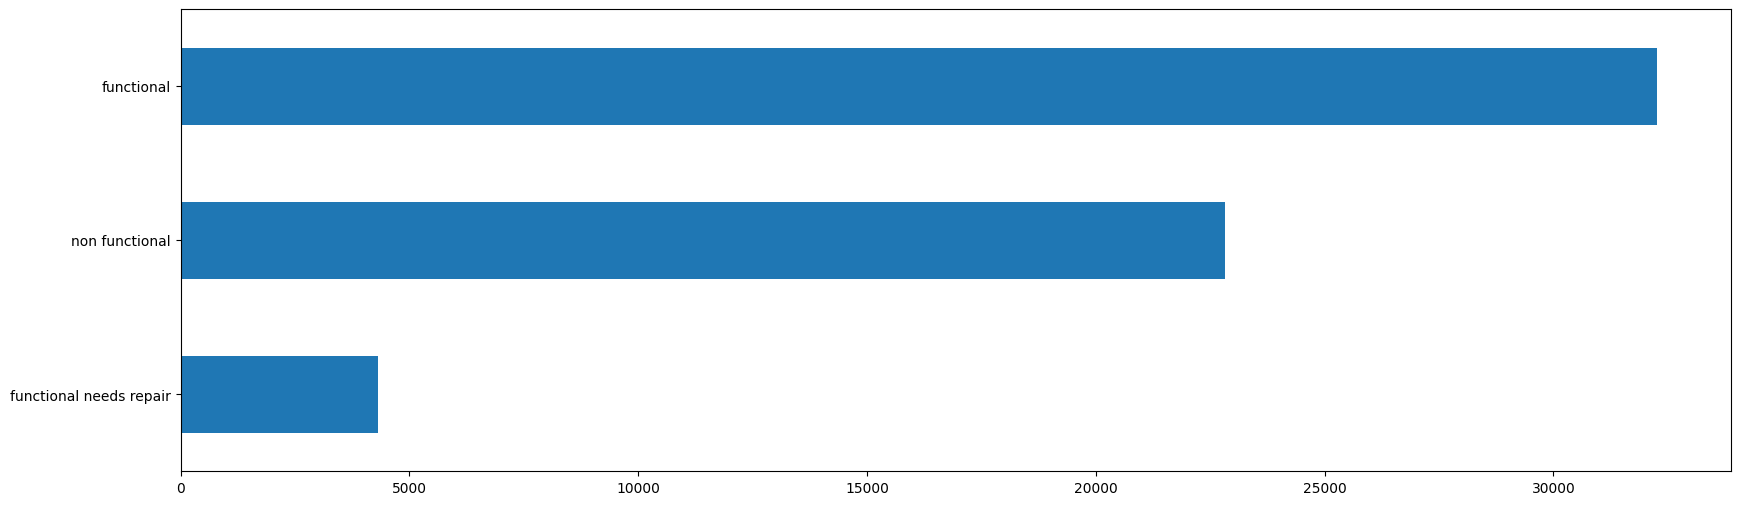

In [3]:
df.status_group.value_counts().sort_values().plot(kind="barh")
print(df.status_group.value_counts())
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.status_group = le.fit_transform(df.status_group)
df.status_group.value_counts()

### Label encoder me dejó labels fáciles de entender, 0 es lo mejor (funcional), luego nees repair (1), y como peor 2, non functional

In [4]:
for i in df.select_dtypes(include = "O").columns:
    df[i] = df[i].astype("category")

In [5]:
df.funder.dtype.name

'category'

In [6]:
df["random"] = np.random.uniform(0,1, size=df.shape[0])
df["random2"] = np.random.uniform(0,1, size=df.shape[0])
a_sacar = ["date_recorded","funder"]
tablaCramer = pd.DataFrame(df.drop(a_sacar,axis=1).apply(lambda x: jd.cramers_v(x, df.status_group)),columns=['VCramer'])

px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente al Beneficio').update_yaxes(categoryorder="total ascending")

# Tenemos unas categóricas con mucha asociación cramer con la objetivo, pero que tienen una cantidad bárbara de categorías

In [7]:
tablaCramer["tipo"] = [df[x].dtype.name for x in tablaCramer.index.tolist()]
tablaCramer["Cant_valores_unicos"] = [df[x].nunique() for x in tablaCramer.index.tolist()]
tablaCramer.sort_values(ascending=False,by="VCramer")



,VCramer,tipo,Cant_valores_unicos
status_group,1.000000,int64,3
wpt_name,0.809527,category,37400
subvillage,0.682880,category,19287
scheme_name,0.588342,category,2696
ward,0.469122,category,2092
installer,0.363391,category,2145
lga,0.311533,category,125
quantity_group,0.309240,category,5
quantity,0.309240,category,5
waterpoint_type,0.250426,category,7


In [8]:
#Al graficarlo me di cuenta
df.num_private = df.num_private.astype("category")

In [9]:
tablaCramer.loc["region_code"]

VCramer                0.084304
tipo                      int64
Cant_valores_unicos          27
Name: region_code, dtype: object

In [10]:
#mat = jd.get_cat_corr_mat(df.drop(a_sacar,axis=1))
#sns.heatmap(annot=True,cmap="coolwarm")

In [11]:
tablaCramer.index

Index(['id', 'amount_tsh', 'gps_height', 'installer', 'longitude', 'latitude',
       'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'random', 'random2'],
      dtype='object')

In [12]:
def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(20,12), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """
    # Definir tamaño letra
    sns.set(font_scale=font_scale)
    # Crear ventana para los subgráficos
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)
    # Crear histograma
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Pintar una línea con la media
    ax_hist2.axvline(np.mean(data),color='red',linestyle='--')
    # Pintar una línea con la mediana
    ax_hist2.axvline(np.median(data.dropna()),color='blue',linestyle='-')
    # Asignar título y nombre de eje si tal
    if xlabel: ax_hist2.set(xlabel=xlabel)
    #if title: ax_box2.set(title=title, xlabel="")
    ax_box2.set(title=data.name, xlabel="")
    #leyenda
    plt.legend(handles=[
    plt.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Mean'),
    plt.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='Median')
    ], labels=['Mean (-)', 'Median (--)'])

    # Mostrar gráfico
    plt.show()

In [13]:
df.dtypes

id                          int64
amount_tsh                float64
date_recorded            category
funder                   category
gps_height                  int64
installer                category
longitude                 float64
latitude                  float64
wpt_name                 category
num_private              category
basin                    category
subvillage               category
region                   category
region_code                 int64
district_code               int64
lga                      category
ward                     category
population                  int64
public_meeting           category
recorded_by              category
scheme_management        category
scheme_name              category
permit                   category
construction_year           int64
extraction_type          category
extraction_type_group    category
extraction_type_class    category
management               category
management_group         category
payment       

# Empiezo mi EDA de variables numéricas

## amount_tsh: complicada, muchos valores centrados en el cero, muchos outliers

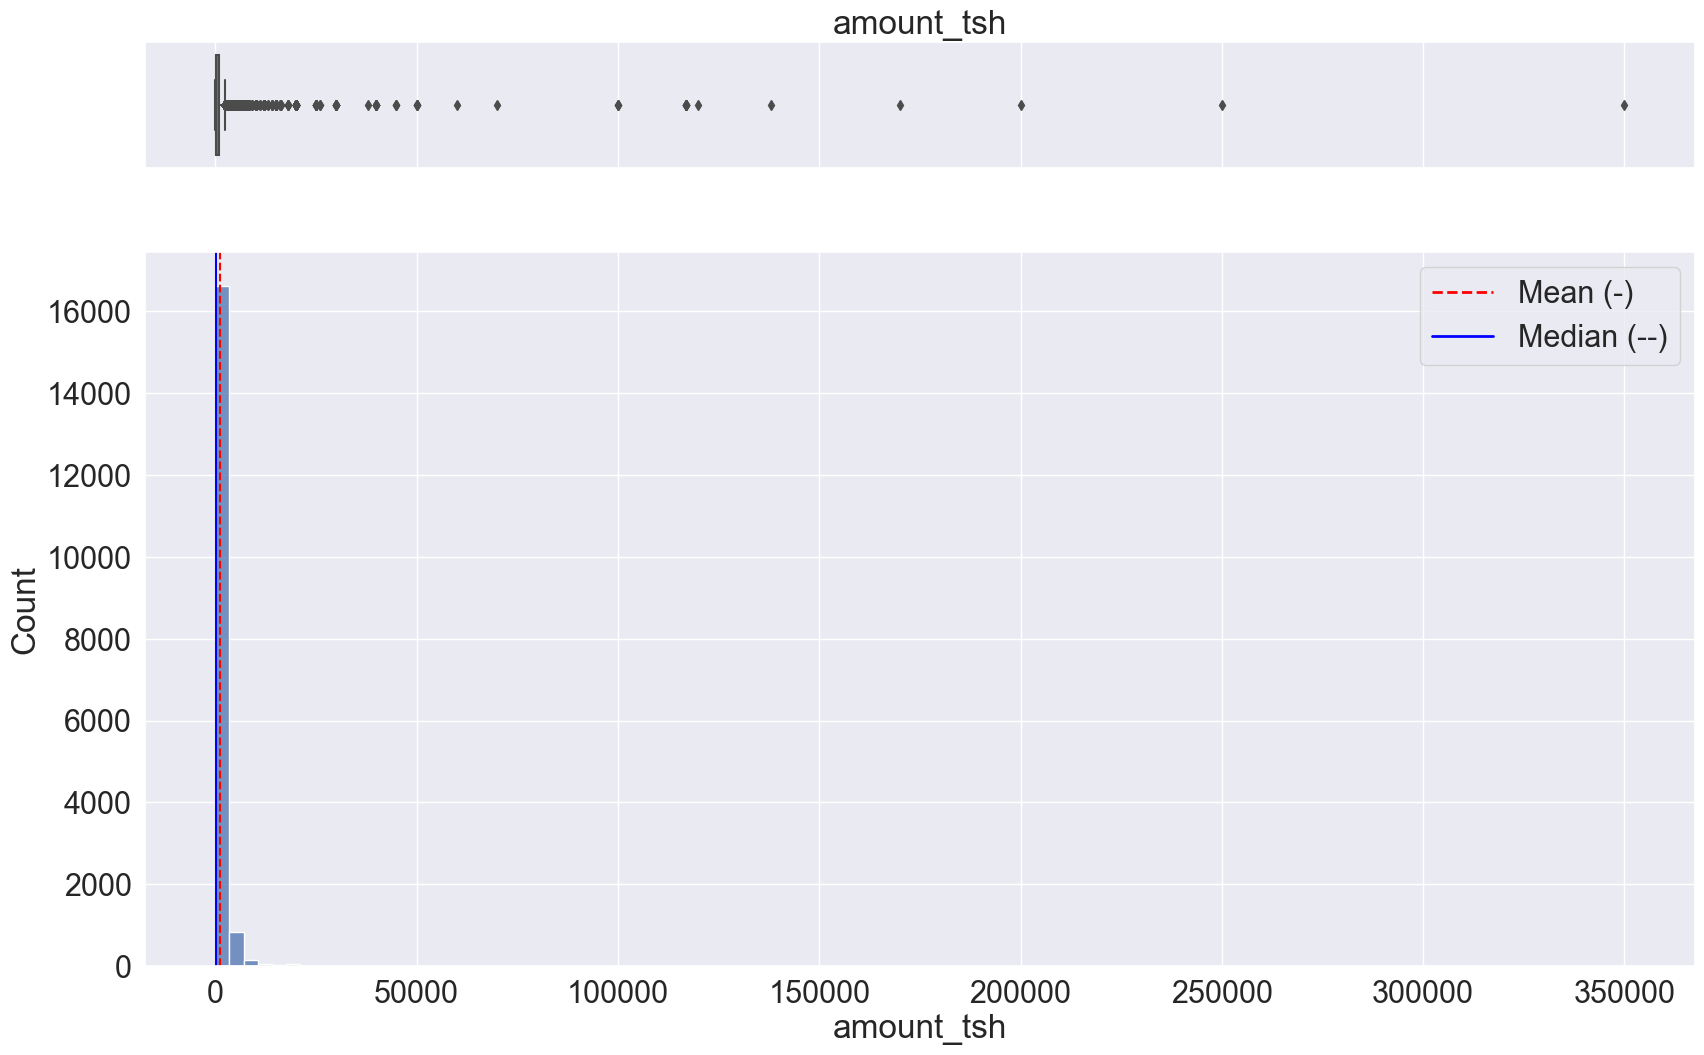

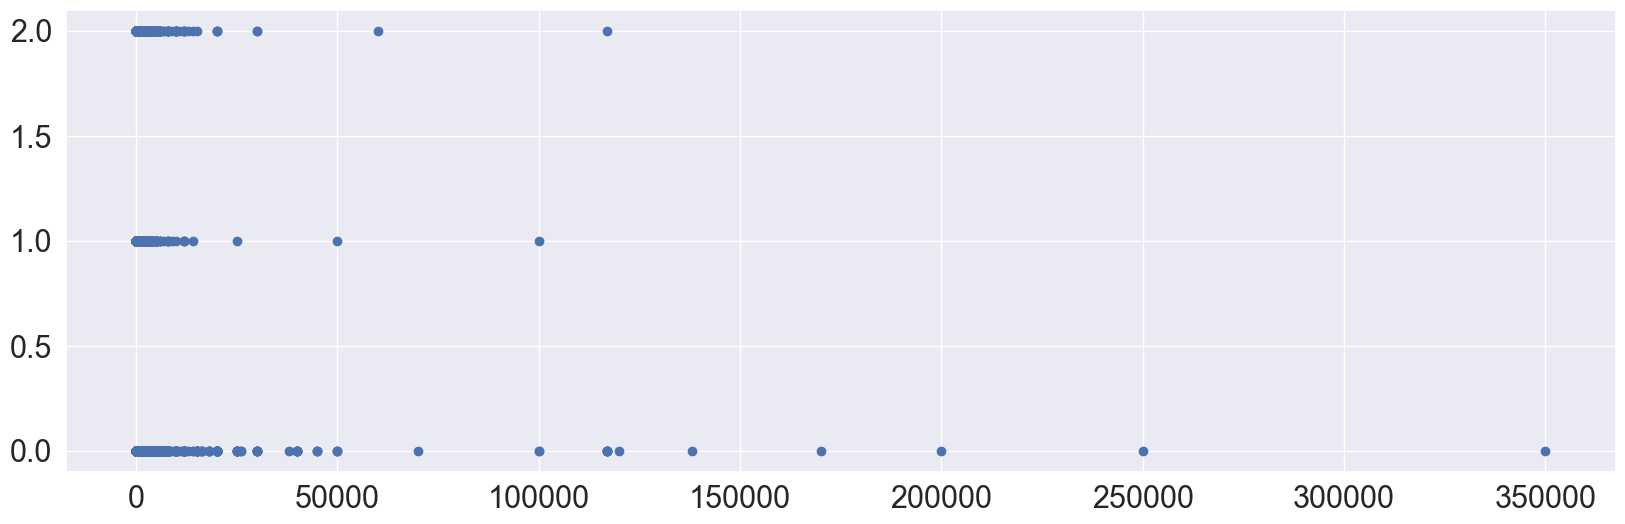

In [14]:
histogram_boxplot(df[df["amount_tsh"]!=0]["amount_tsh"],bins=100)
plt.show()
df[df["amount_tsh"]!=0]["amount_tsh"].value_counts().sort_index()
plt.scatter(x=df.amount_tsh,y=df.status_group)
plt.show()

Text(0.5, 1.0, 'Distribución tal cual')

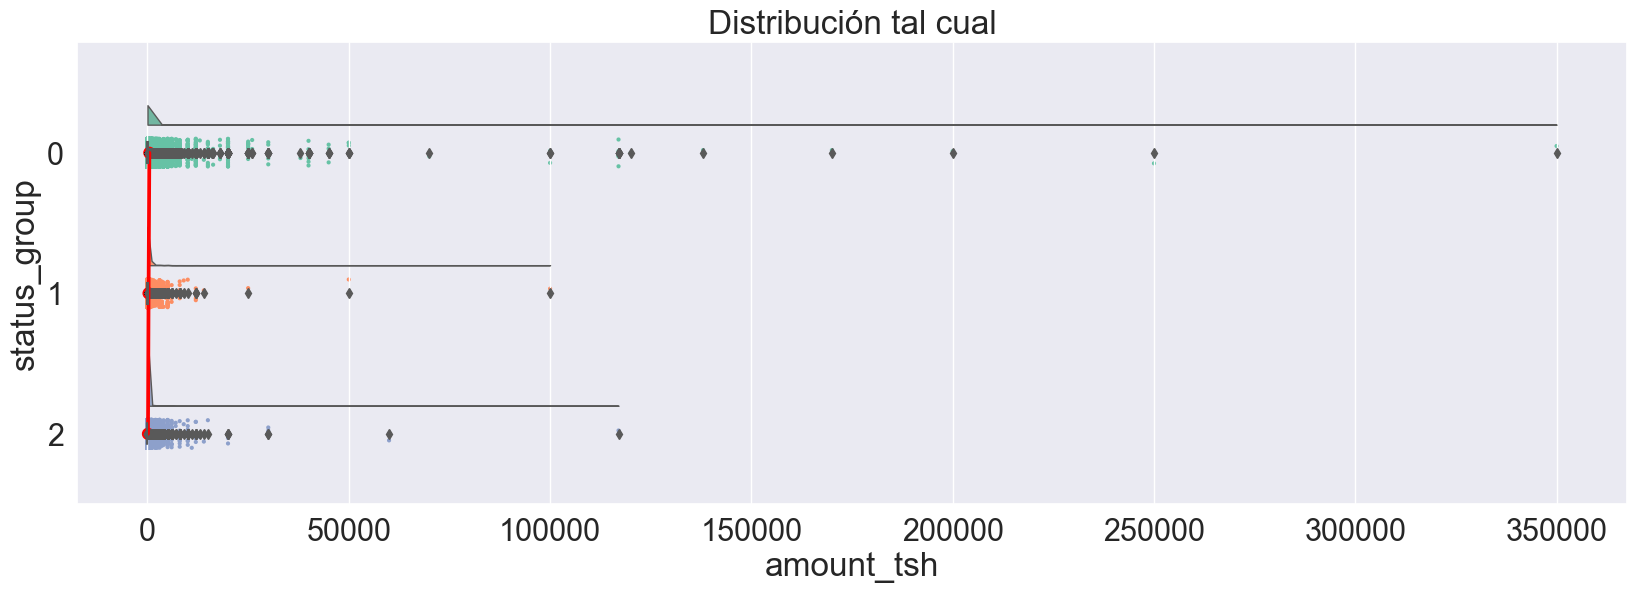

In [15]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Sacando outliers >50000')

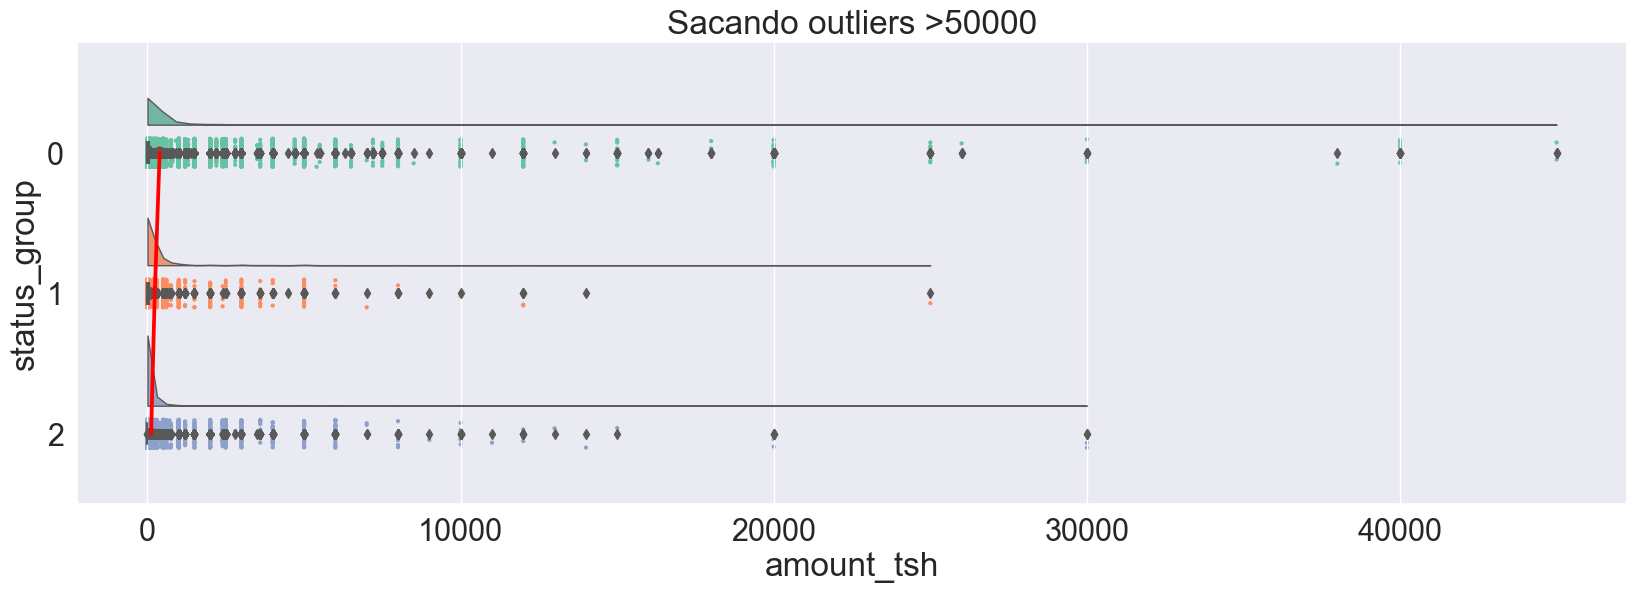

In [16]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[df["amount_tsh"]<50000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >50000")

0    19706
2    18885
1     3048
Name: status_group, dtype: int64

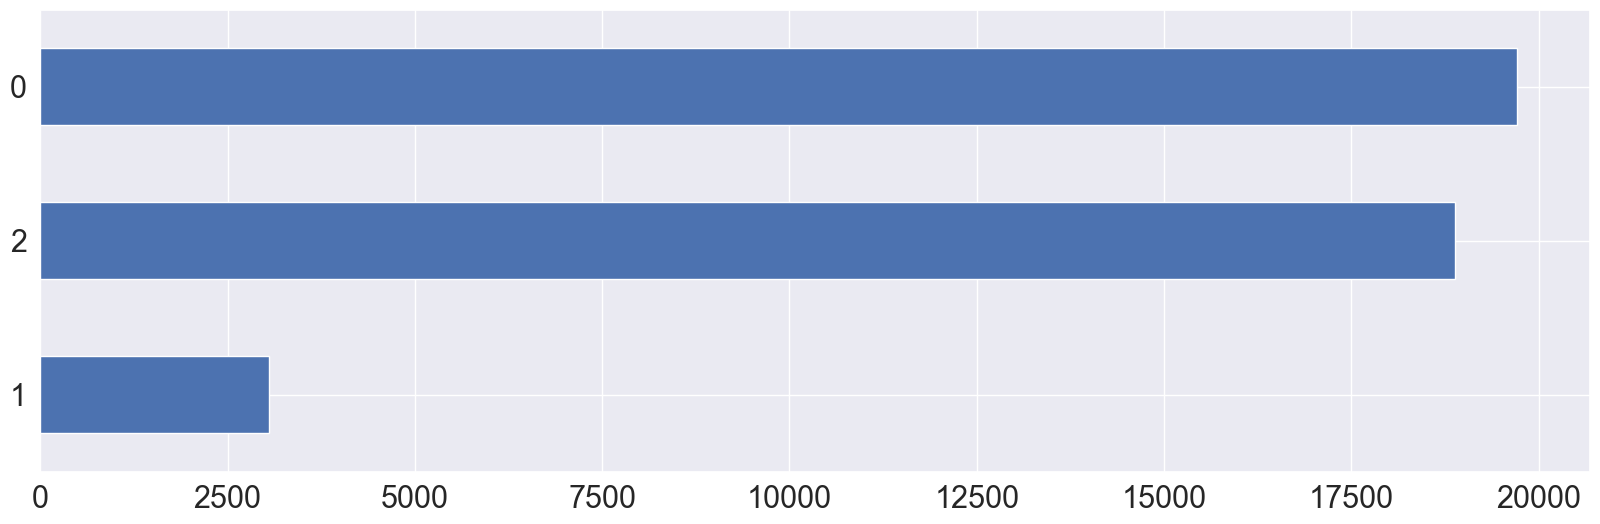

In [17]:
df[df["amount_tsh"]==0]["status_group"].value_counts().sort_values().plot(kind="barh")
df[df["amount_tsh"]==0]["status_group"].value_counts()

Text(0.5, 1.0, 'Sacando outliers >50000 y valores 0')

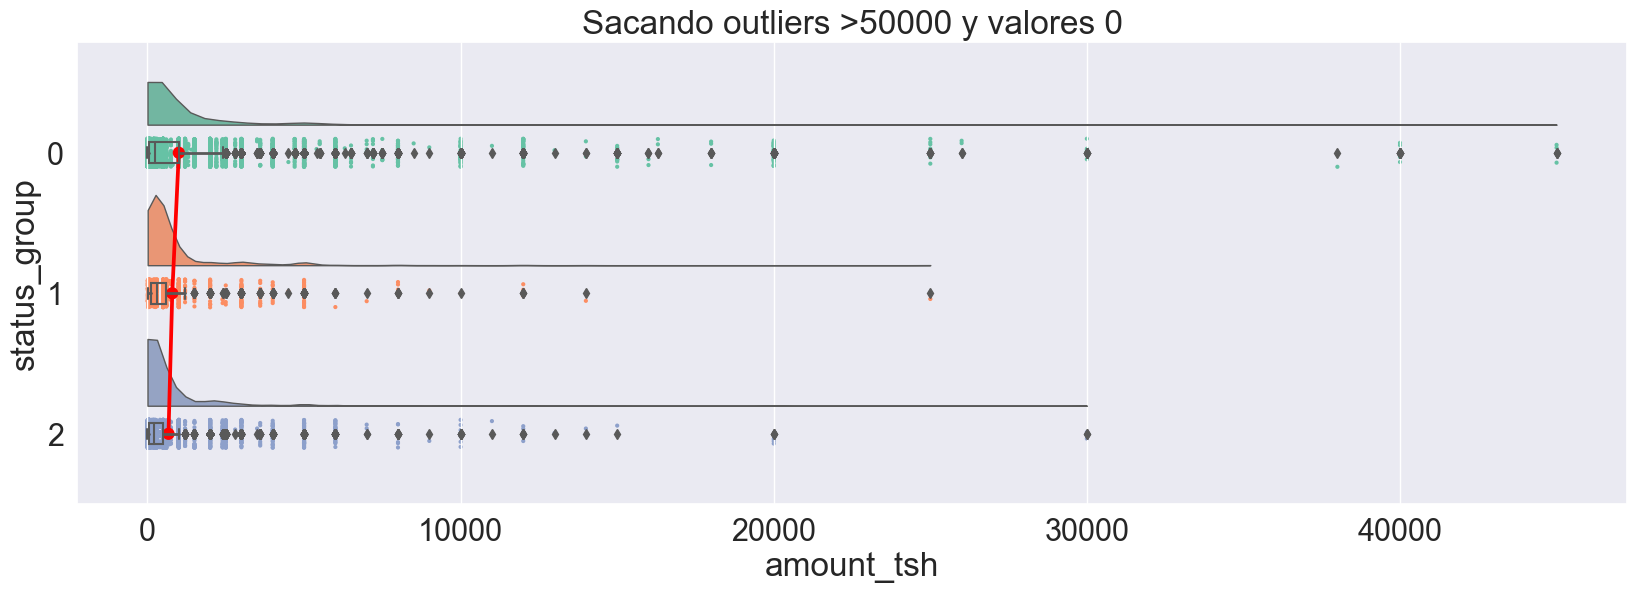

In [18]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<50000) & (df["amount_tsh"]!=0)],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >50000 y valores 0")

Text(0.5, 1.0, 'Sacando outliers >10000 y valores 0')

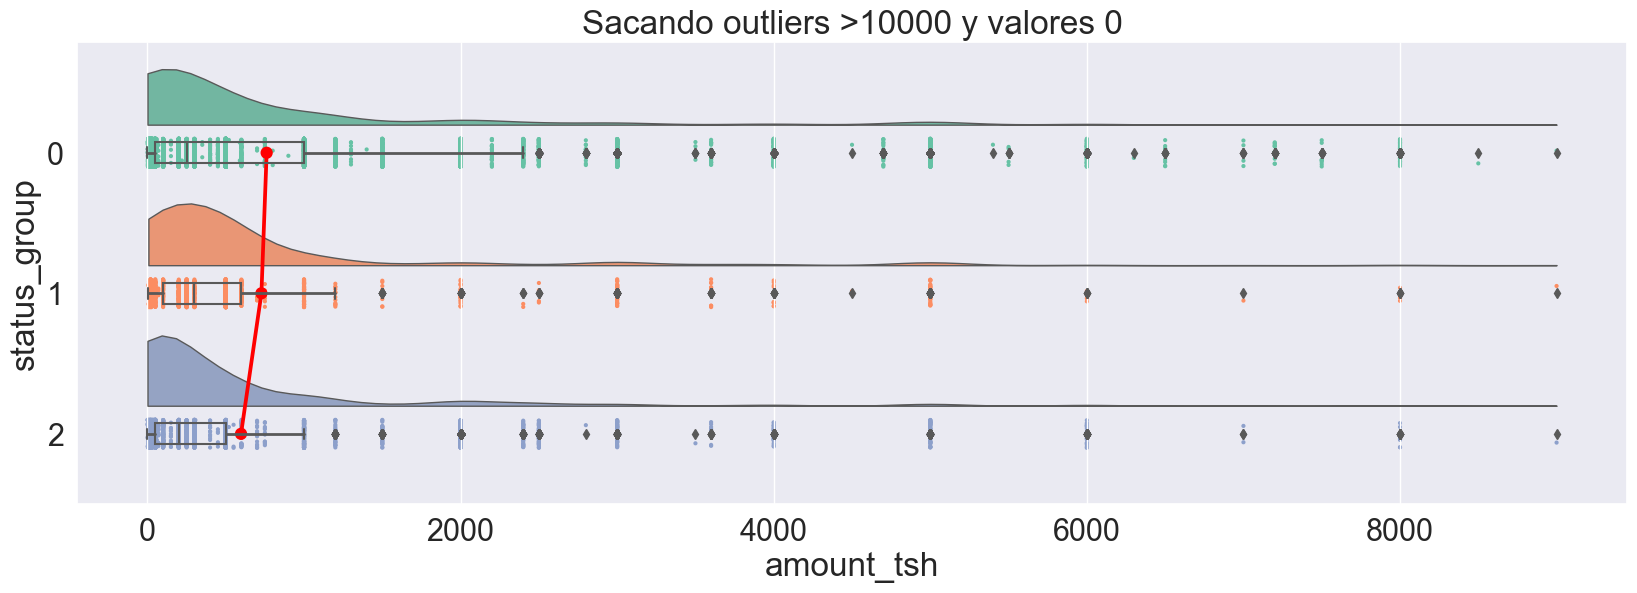

In [19]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<10000) & (df["amount_tsh"]!=0)],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >10000 y valores 0")

Text(0.5, 1.0, 'Sacando valores >2000 y valores 0')

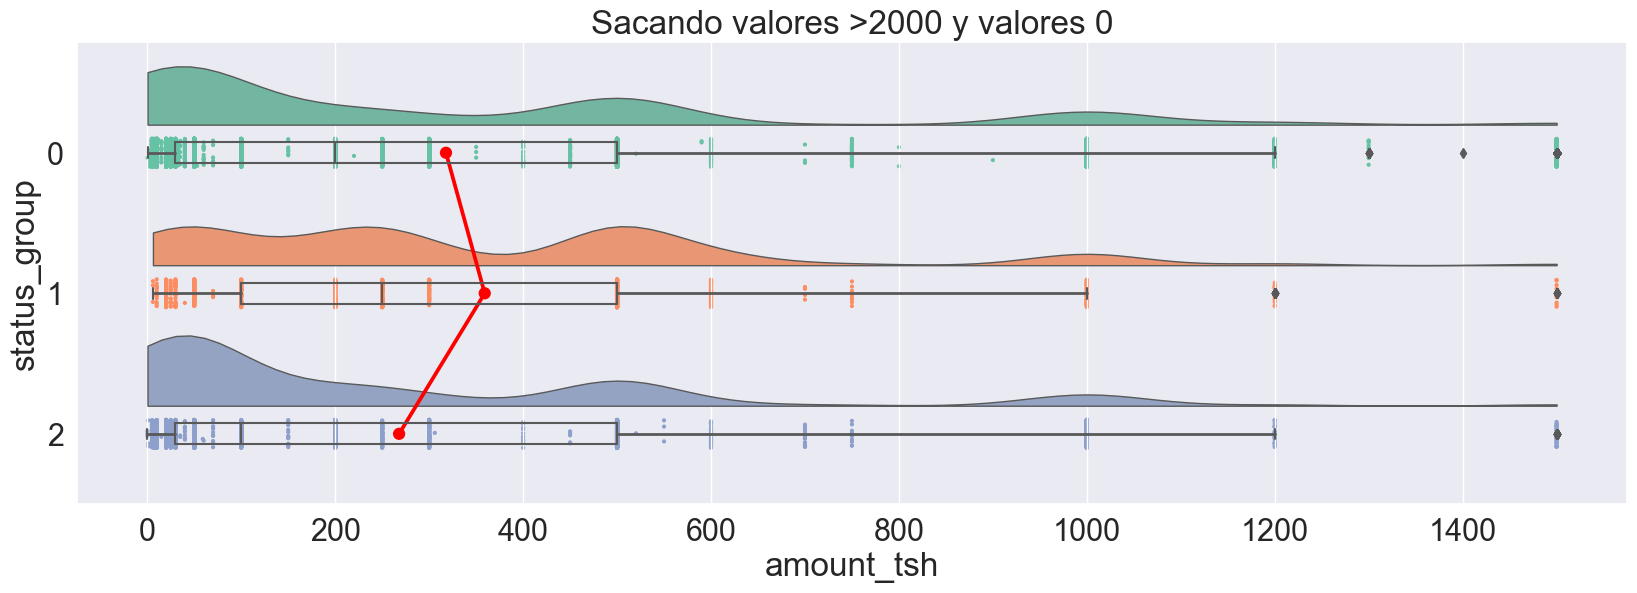

In [20]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<2000) & (df["amount_tsh"]!=0)],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando valores >2000 y valores 0")

# gps_height

Text(0.5, 1.0, 'Distribución tal cual')

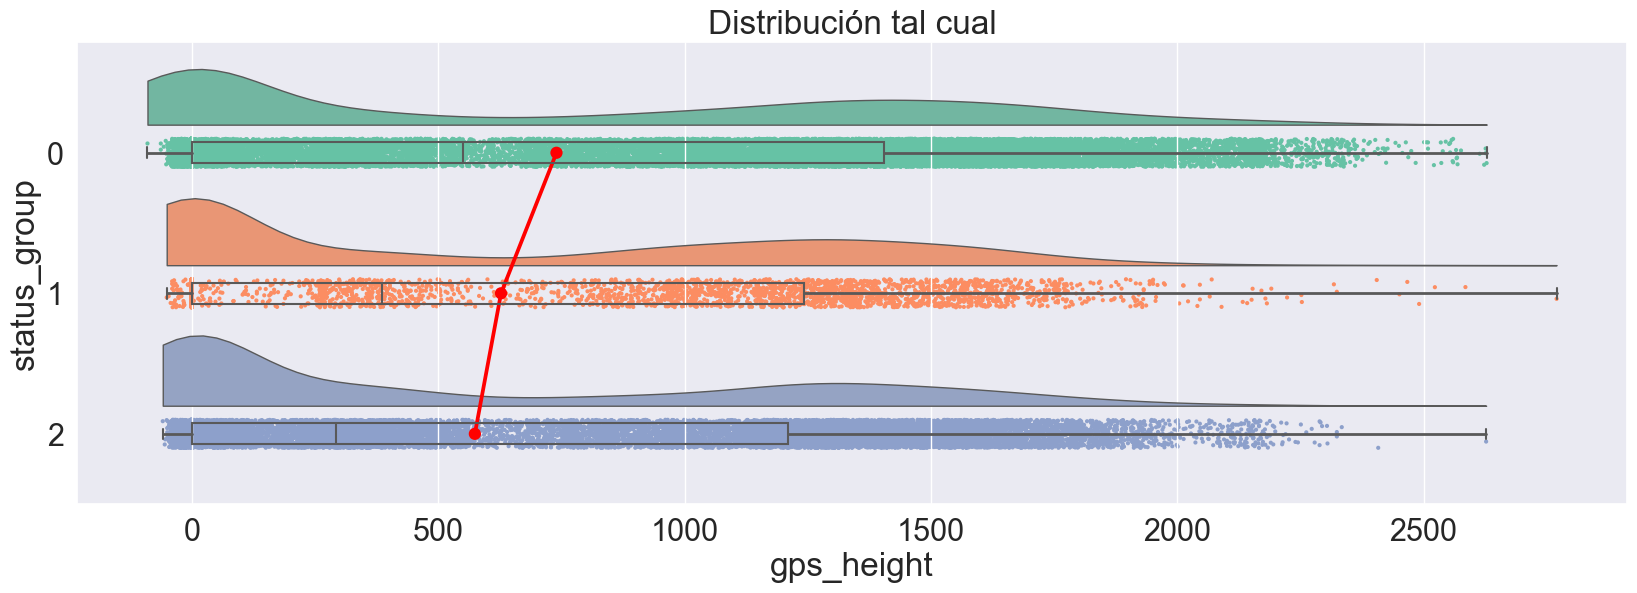

In [21]:
pt.RainCloud(x = "status_group", y = "gps_height", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

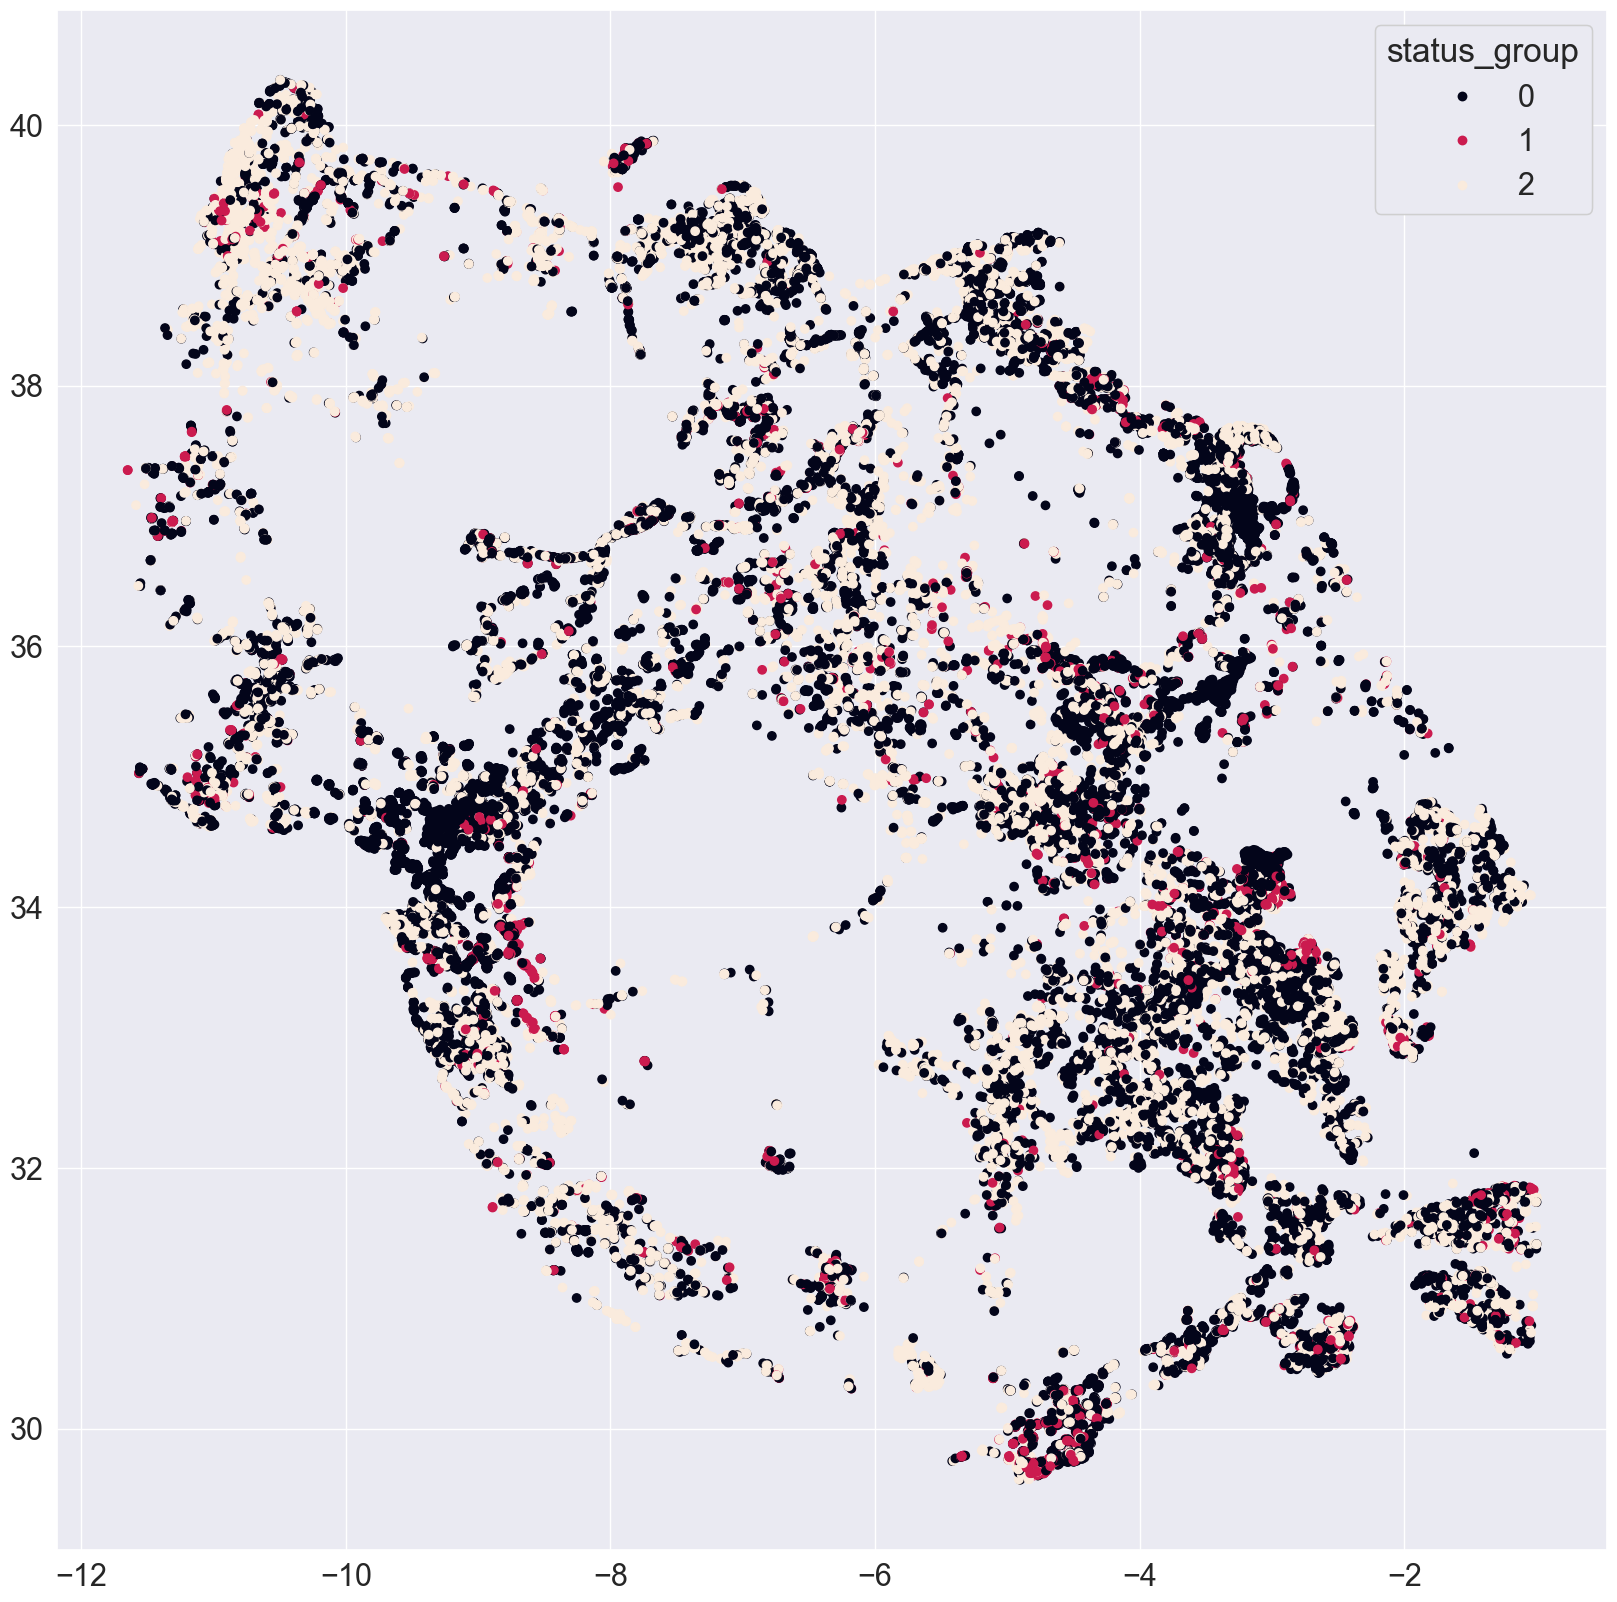

In [22]:
df_geo = df[["latitude","longitude","status_group"]].copy()
df_geo = df_geo[(df_geo["latitude"]!=0)&(df_geo["longitude"]!=0)]

fig,ax = plt.subplots(figsize=(20,20))
scatter = ax.scatter(x=df_geo.latitude,y=df_geo.longitude,c=df_geo.status_group)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="status_group")
ax.add_artist(legend1)
plt.savefig('Graphs/Latitudlongitud.pdf')  


In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [24]:
import joblib

In [25]:
df_geo.drop("status_group",axis=1,inplace=True)

### Lo que viene a continuación tarda demasiado tiempo y la primera vez lo hice (Jueves Santo) incluyendo status_group en el algoritmo, lo cual es por su puesto erróneo porque así no se pude transformar X_test

In [26]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

#Scaler = MinMaxScaler()
#df_geo.latitude = Scaler.fit_transform(df_geo.latitude.values.reshape(-1,1))
#df_geo.longitude = Scaler.fit_transform(df_geo.longitude.values.reshape(-1,1))

clustering = AgglomerativeClustering(linkage="ward", n_clusters=None,
                            distance_threshold = 0)
#clustering.fit(df_geo.to_numpy())

#joblib.dump(clustering, 'Models/LocationClustering.joblib')
clustering = joblib.load('Models/LocationClustering.joblib')

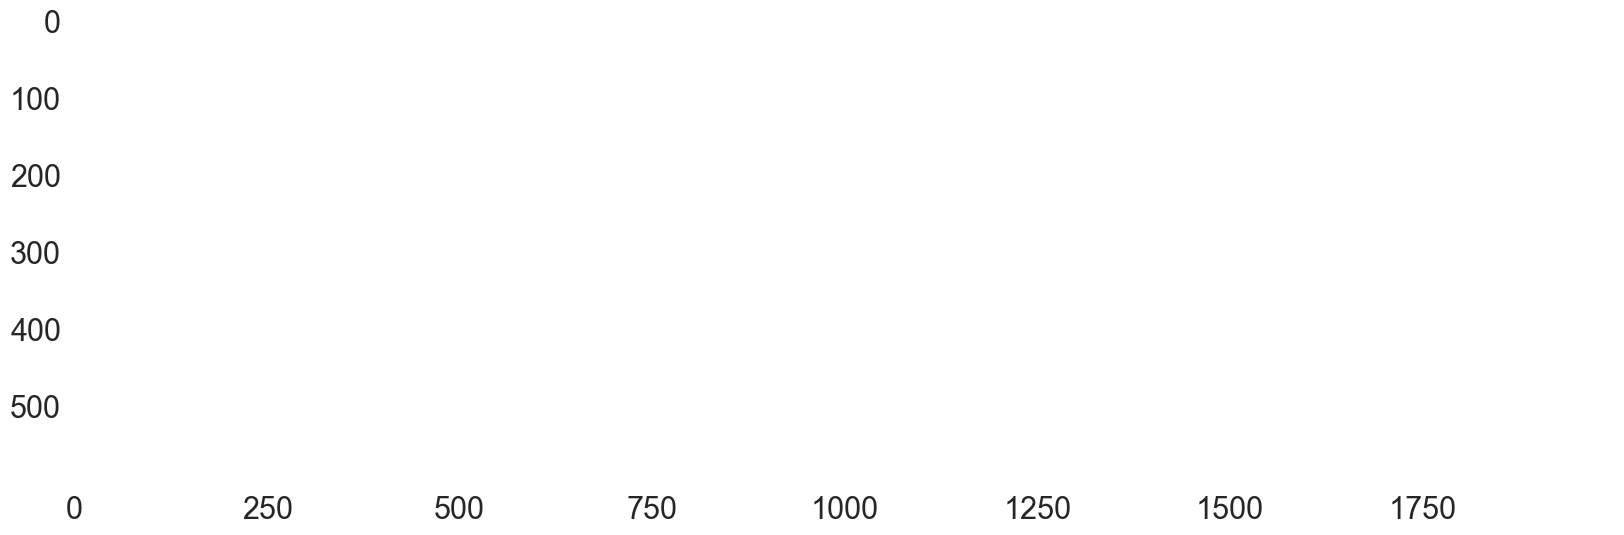

In [27]:
#jd.plot_dendogram(clustering)
#plt.savefig('Graphs/Dendograma_location.png')

Dendograma_location = plt.imread('Graphs/Dendograma_location.png')
plt.imshow(Dendograma_location)
plt.show()


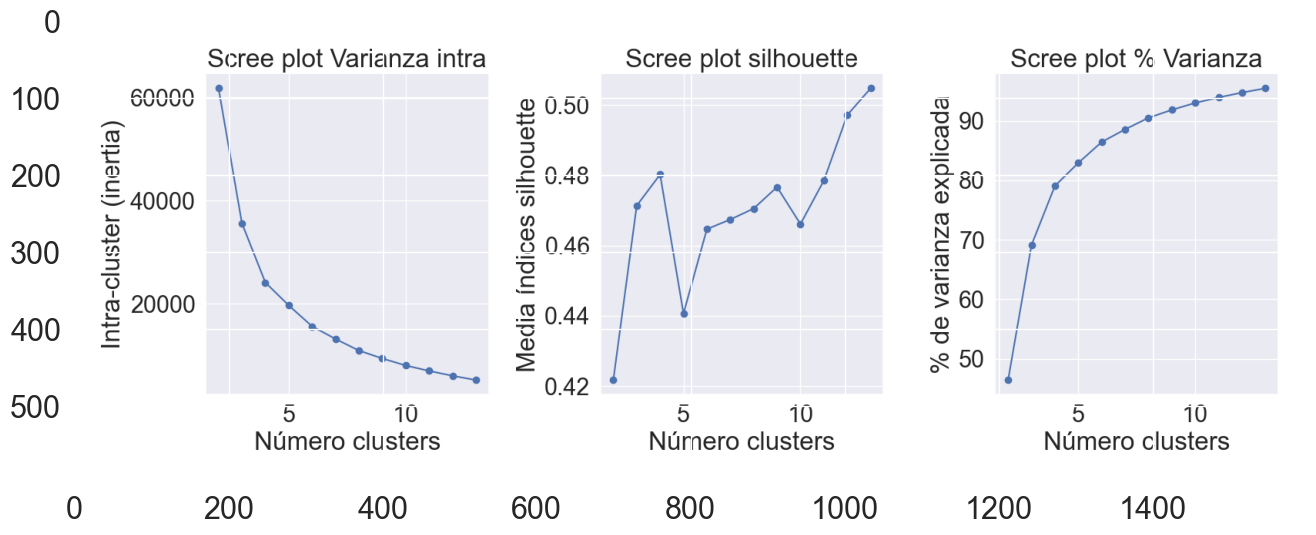

In [28]:
#jd.scree_plot_kmeans(df_geo,14)
#plt.savefig('Graphs/SkreePlot_location.png')
SkreePlot_location = plt.imread('Graphs/SkreePlot_location.png')
plt.imshow(SkreePlot_location)
plt.show()

In [29]:
#6-7 clusters parece ser la solución

In [30]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=7)
df_geo["location_cluster"] = clustering.fit_predict(df_geo)

In [31]:
X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
X_test["location_cluster"] = clustering.predict(X_test[["latitude","longitude"]].to_numpy())

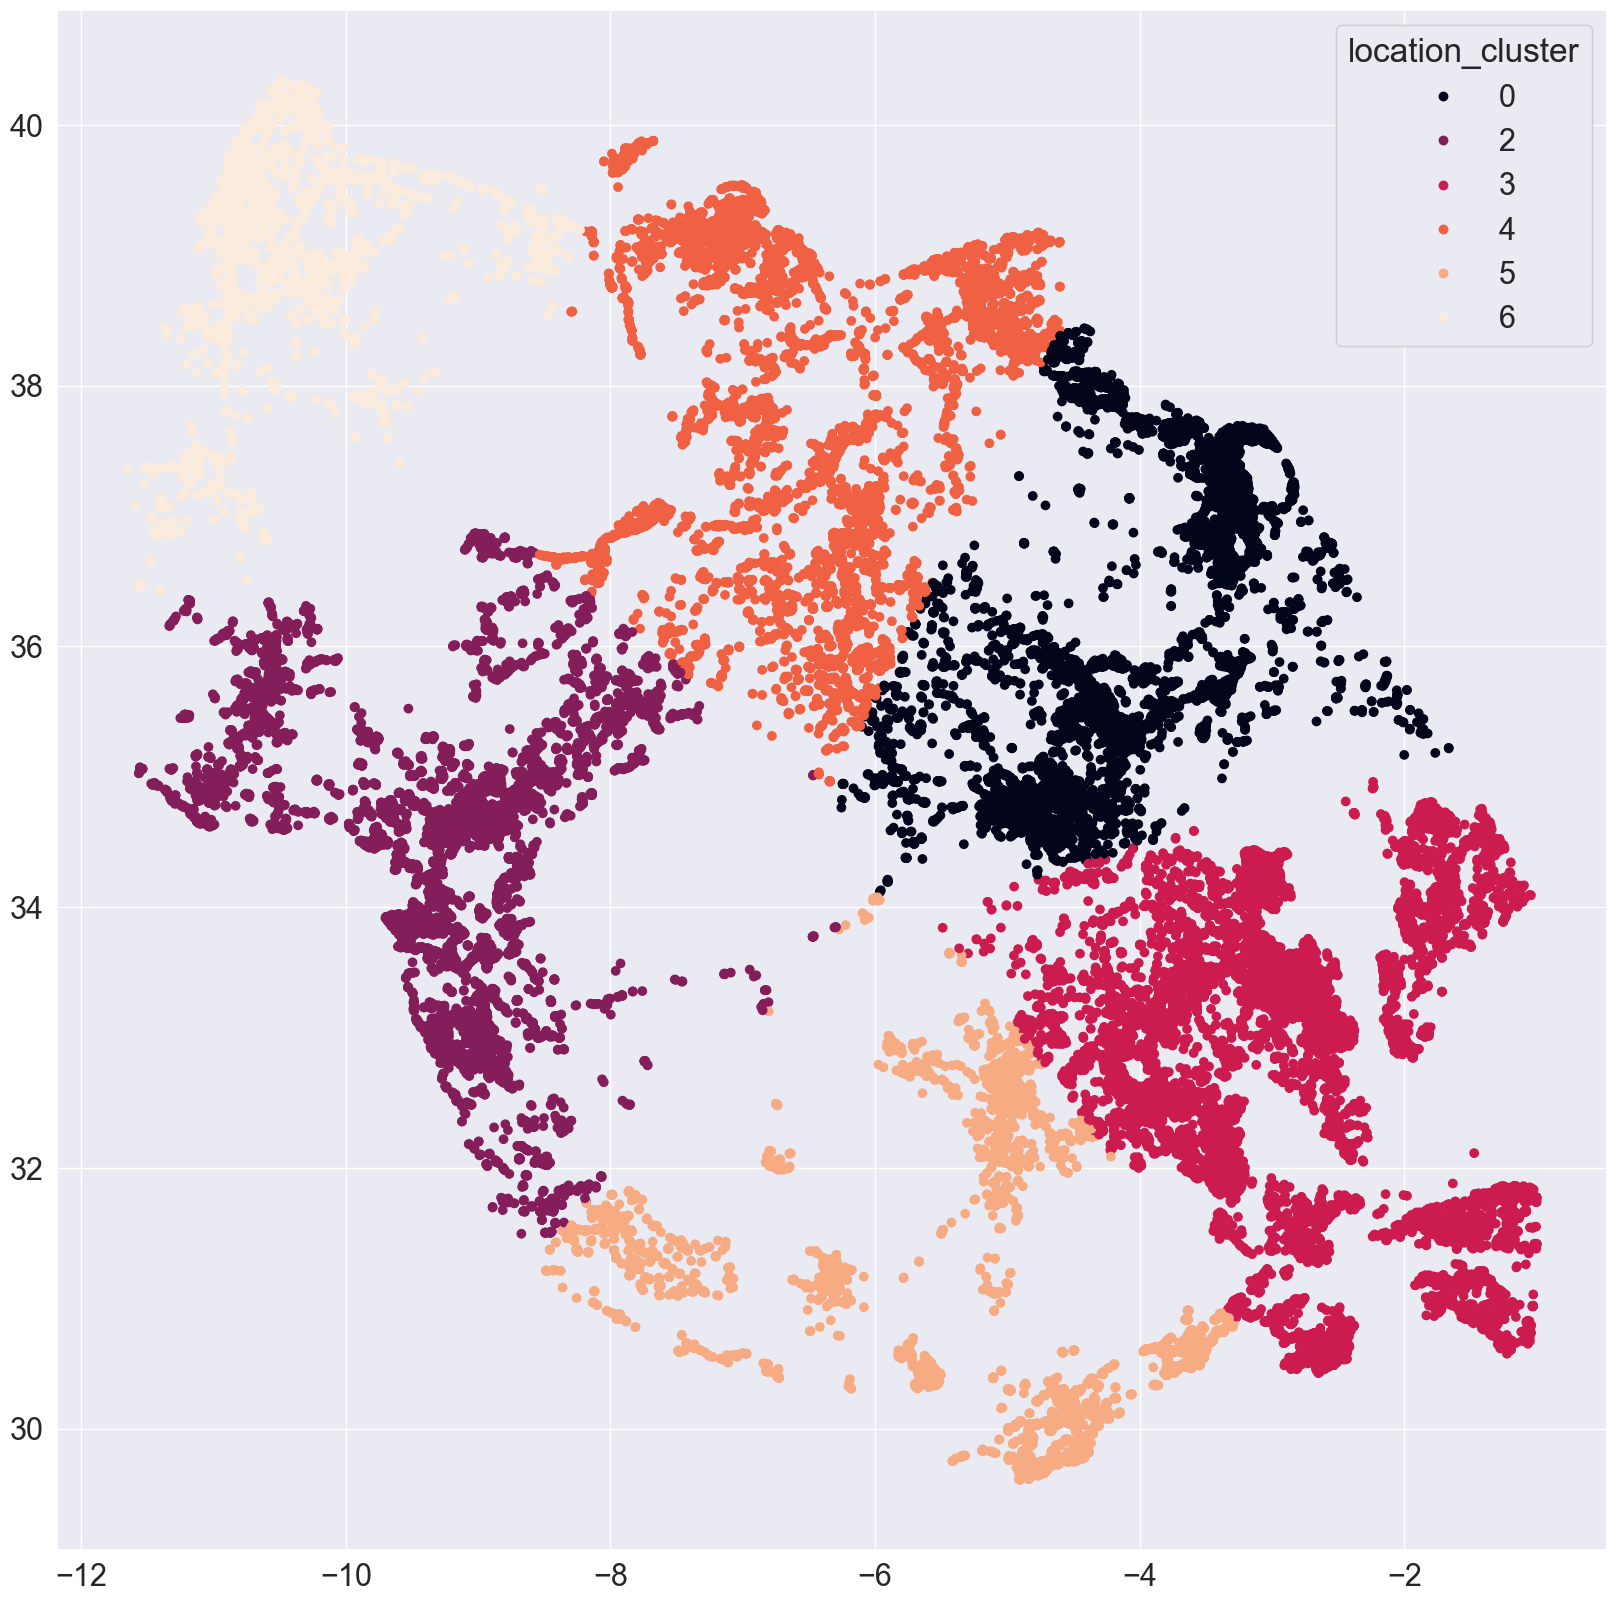

In [32]:
X_geo = X[["latitude","longitude","location_cluster"]].copy()
X_geo = X_geo[(X_geo["latitude"]!=0)&(X_geo["longitude"]!=0)]

fig,ax = plt.subplots(figsize=(20,20))
scatter = ax.scatter(x=X_geo.latitude,y=X_geo.longitude,c=X_geo.location_cluster)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="location_cluster")
ax.add_artist(legend1)
plt.savefig('Graphs/Latitudlongitud7Clusters.pdf')  


In [33]:
X_geo.isna().sum()

latitude            0
longitude           0
location_cluster    0
dtype: int64

In [34]:
X.drop(["longitude","latitude"],axis=1,inplace=True)
X_test.drop(["longitude","latitude"],axis=1,inplace=True)

In [35]:
X.to_csv("Out/XReemplazoLongitudeLatitudeConClusters.csv")
X_test.to_csv("Out/X_testReemplazoLongitudeLatitudeConClusters.csv")

In [36]:
X.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity

In [37]:
df_geo["location_cluster"]

0        2
1        3
2        1
3        5
4        6
        ..
59395    1
59396    2
59397    2
59398    4
59399    4
Name: location_cluster, Length: 57588, dtype: int32

In [38]:
#joblib.dump(clustering, 'Models/LocationClustering.joblib')
#LoadedClusterin = joblib.load('Models/LocationClustering.joblib')

### Num_private aunque es numérico parece que se comporta como una categórica, sólo tiene 65 valores únicos

In [39]:
#pt.RainCloud(x = "status_group", y = "num_private", data = df,width_viol = 1,orient = "h",pointplot=True)
#plt.title("Distribución tal cual")

# REGION CODE CATEGÓRICA O NUMÉRICA?

# REGION CODE CATEGÓRICA O NUMÉRICA?: PROBABLEMENTE AMBOS REGION Y DISTRICT CODE SE COMPORTEN COMO VARIABLES CATEGÓRICAS

Text(0.5, 1.0, 'Distribución tal cual')

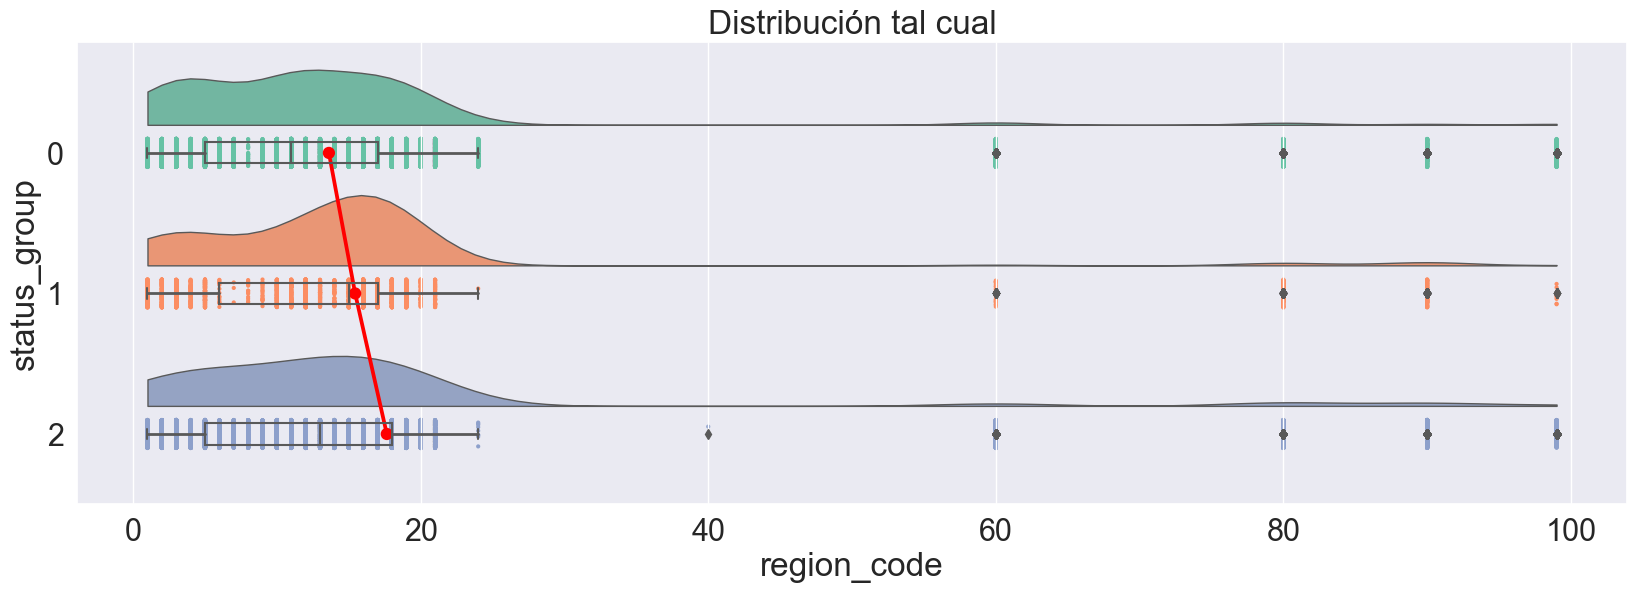

In [40]:
pt.RainCloud(x = "status_group", y = "region_code", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Distribución tal cual')

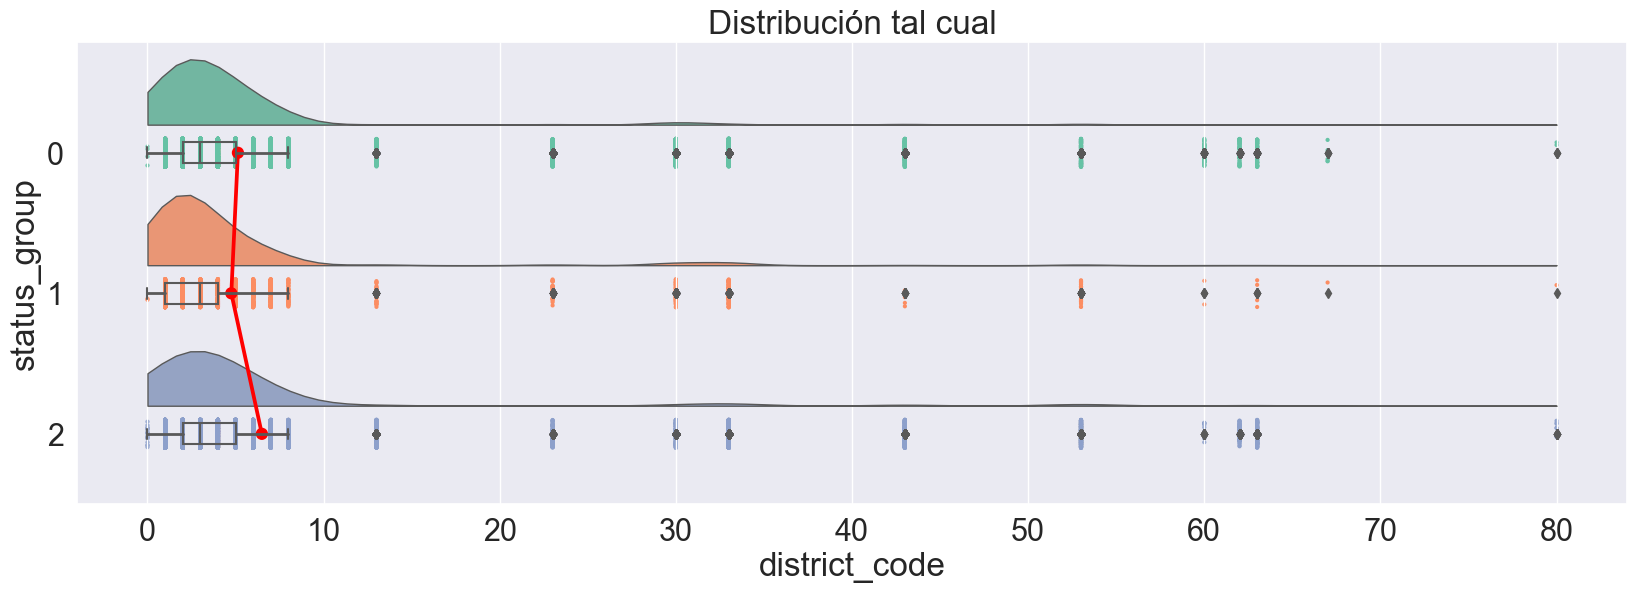

In [41]:
pt.RainCloud(x = "status_group", y = "district_code", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Distribución tal cual')

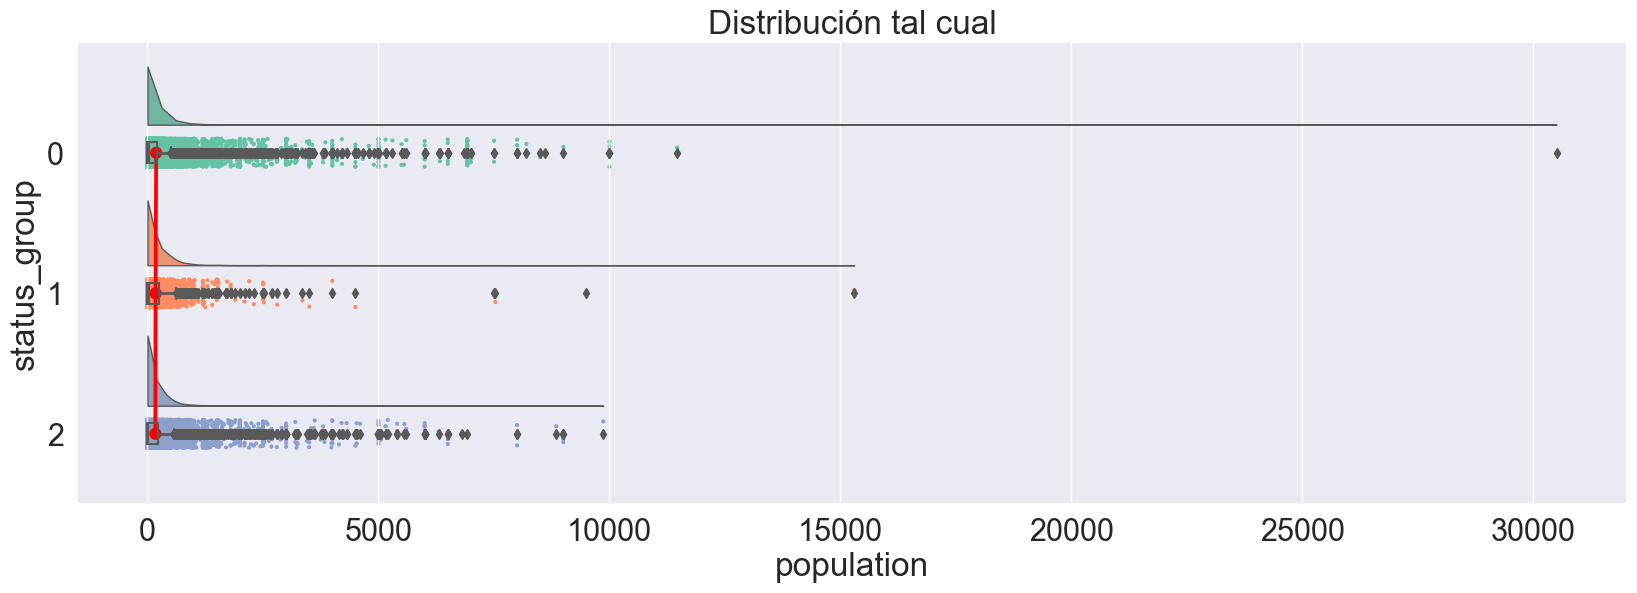

In [42]:
pt.RainCloud(x = "status_group", y = "population", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Distribución con valores menores a 5mil')

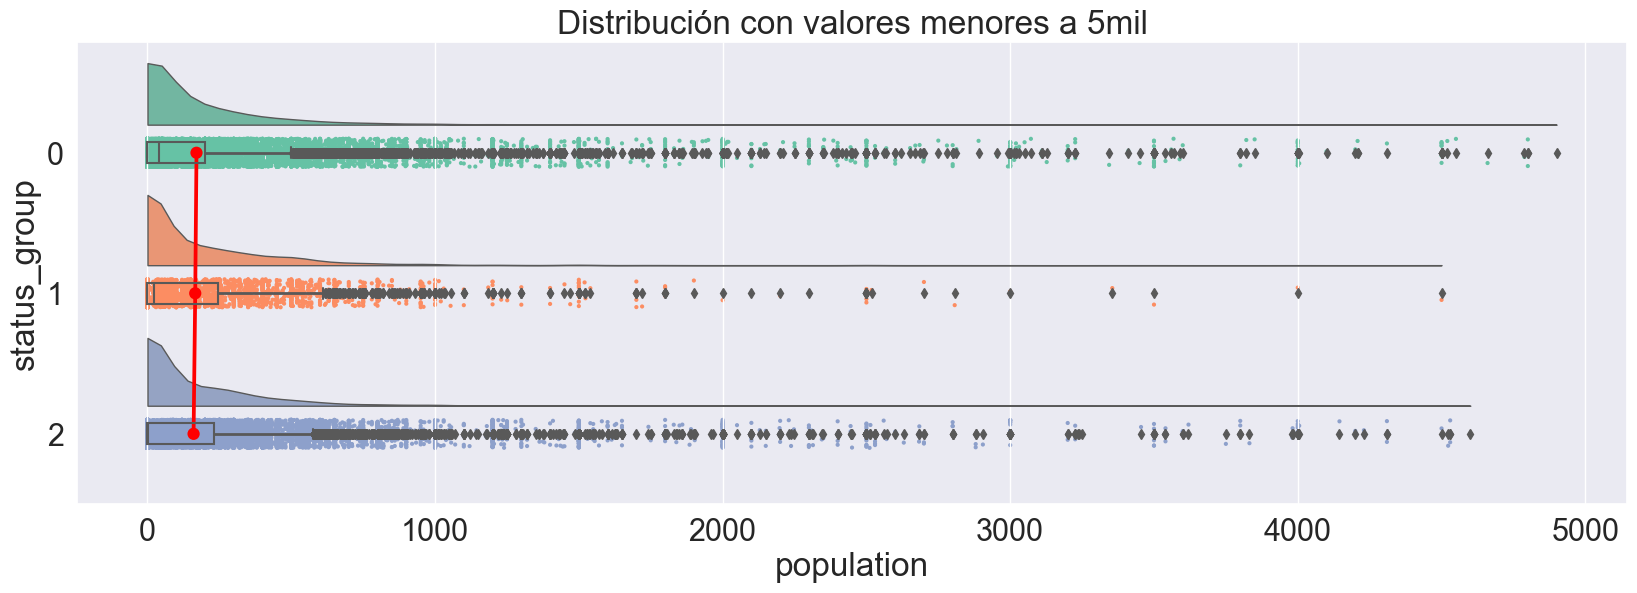

In [43]:
pt.RainCloud(x = "status_group", y = "population", data = df[df["population"]<5000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución con valores menores a 5mil")

Text(0.5, 1.0, 'Distribución con valores menores a mil')

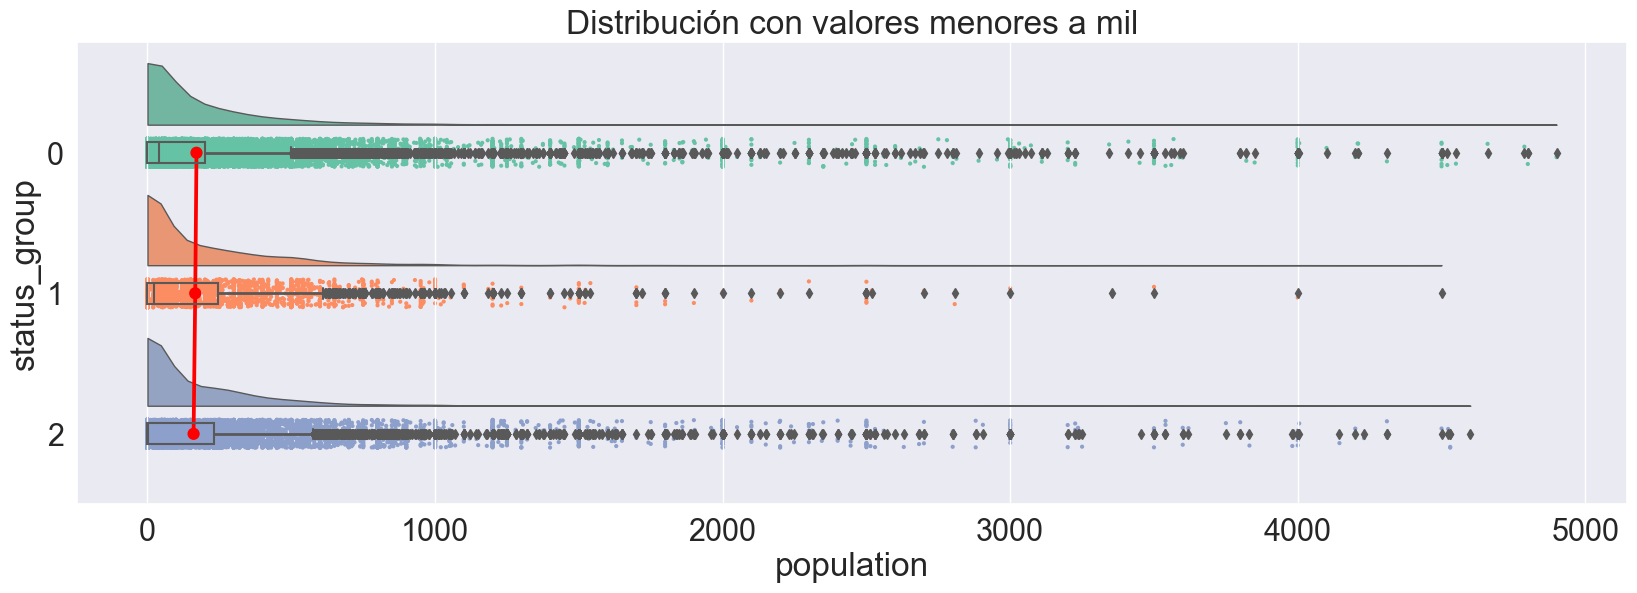

In [44]:
pt.RainCloud(x = "status_group", y = "population", data = df[df["population"]<5000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución con valores menores a mil")

<AxesSubplot: xlabel='construction_year'>

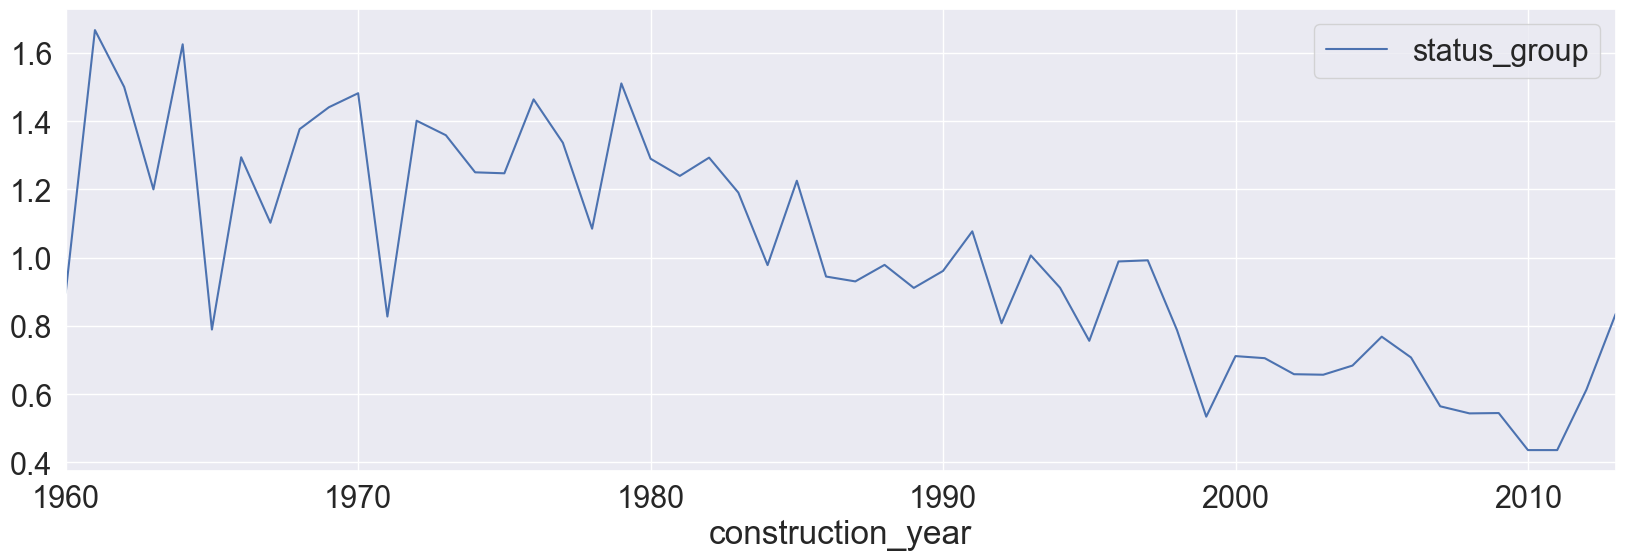

In [45]:
df_temp = df[["construction_year","status_group"]]

df_temp.construction_year = df_temp.construction_year.apply(lambda x: x if x!= 0 else 1960)
df_temp.construction_year = pd.to_datetime(df_temp.construction_year, format='%Y')#.dt.year
df_temp.groupby("construction_year").mean().plot()

In [46]:
df.construction_year

0        1999
1        2010
2        2009
3        1986
4           0
         ... 
59395    1999
59396    1996
59397       0
59398       0
59399    2002
Name: construction_year, Length: 59400, dtype: int64

In [47]:
df.select_dtypes(include=np.number).columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'region_code', 'district_code', 'population', 'construction_year',
       'status_group', 'random', 'random2'],
      dtype='object')

In [48]:
df.select_dtypes(exclude=np.number).columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

# AHORA LAS VARIABLES CATEGÓRICAS: empezaré usando optbinning


In [49]:
#optb = MulticlassOptimalBinning(max_n_bins=None,max_pvalue=0.10).fit(df.funder,df.status_group)
#ValueError: x array after removing special codes and missing values must be numerical.


## Al parecer OptBinning sólo tiene implementación para hacer agrupaciones de variables categóricas cuando el target es binario :(

In [50]:
df.select_dtypes(include=np.number).columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'region_code', 'district_code', 'population', 'construction_year',
       'status_group', 'random', 'random2'],
      dtype='object')

In [51]:
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [52]:
y
y = le.fit_transform(y.status_group)

In [53]:
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
preprocessing = ColumnTransformer([
    ('target_enc', TargetEncoder(), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X_transformed = preprocessing.fit_transform(X,y=y)
transformed_columns = preprocessing.get_feature_names_out()

# Create DataFrame from transformed data
X_transformed = pd.DataFrame(data=X_transformed, columns=transformed_columns)
X_transformed

,target_enc__date_recorded,target_enc__funder,target_enc__installer,target_enc__wpt_name,target_enc__basin,target_enc__subvillage,target_enc__region,target_enc__lga,target_enc__ward,target_enc__public_meeting,...,target_enc__waterpoint_type_group,scaler__amount_tsh,scaler__gps_height,scaler__num_private,scaler__region_code,scaler__district_code,scaler__population,scaler__construction_year,scaler__location_cluster,remainder__id
0,0.665385,0.323636,0.712844,0.502386,0.643461,0.740705,0.412354,0.430851,0.765313,0.813295,...,0.763032,1.895665,1.041252,-0.038749,-0.244325,-0.065370,-0.150399,0.733857,-0.361237,69572.0
1,0.681820,0.393857,0.377101,0.869880,0.908177,0.687712,1.069578,0.777933,0.747053,0.946611,...,0.763032,-0.105970,1.054237,-0.038749,0.267409,-0.376781,0.212290,0.745416,0.202306,8776.0
2,0.790614,0.646454,0.558824,0.711231,0.744855,0.996016,0.692356,0.821429,0.668727,0.813295,...,0.763032,-0.097630,0.025541,-0.038749,0.324269,-0.169174,0.148660,0.744365,-1.488323,34310.0
3,1.162234,0.771050,0.887387,0.991936,1.184064,0.933789,1.321387,1.468354,1.443561,0.813295,...,0.763032,-0.105970,-0.584751,-0.038749,4.247564,5.955245,-0.258570,0.720196,1.892936,67743.0
4,0.991667,0.731719,0.844444,0.935355,0.908177,0.721842,0.866707,0.880674,0.664150,0.813295,...,0.763032,-0.105970,-0.964200,-0.038749,0.153691,-0.480585,-0.381587,-1.366788,0.202306,19728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.821622,0.234426,0.234426,0.731719,0.744855,0.699862,0.720712,0.252800,0.051778,0.813295,...,0.763032,-0.102634,0.781553,-0.038749,-0.699200,-0.065370,-0.116463,0.733857,-1.488323,60739.0
59396,0.687712,0.357963,0.523589,0.731719,0.674398,0.543101,0.412354,0.358769,0.612218,0.813295,...,0.763032,1.461977,0.784439,-0.038749,-0.244325,-0.169174,-0.262812,0.730704,-0.361237,27263.0
59397,1.025478,0.789821,0.785226,0.926299,0.674398,0.721842,0.891571,0.792332,1.079280,0.813295,...,0.705455,-0.105970,-0.964200,-0.038749,-0.187465,0.142237,-0.381587,-1.366788,-0.361237,37057.0
59398,0.759146,0.711231,0.833653,0.731719,0.674398,1.011092,0.988187,1.086455,0.964930,0.813295,...,0.705455,-0.105970,-0.964200,-0.038749,-0.812918,-0.169174,-0.381587,-1.366788,0.765850,31282.0


In [54]:
X_transformed

,target_enc__date_recorded,target_enc__funder,target_enc__installer,target_enc__wpt_name,target_enc__basin,target_enc__subvillage,target_enc__region,target_enc__lga,target_enc__ward,target_enc__public_meeting,...,target_enc__waterpoint_type_group,scaler__amount_tsh,scaler__gps_height,scaler__num_private,scaler__region_code,scaler__district_code,scaler__population,scaler__construction_year,scaler__location_cluster,remainder__id
0,0.665385,0.323636,0.712844,0.502386,0.643461,0.740705,0.412354,0.430851,0.765313,0.813295,...,0.763032,1.895665,1.041252,-0.038749,-0.244325,-0.065370,-0.150399,0.733857,-0.361237,69572.0
1,0.681820,0.393857,0.377101,0.869880,0.908177,0.687712,1.069578,0.777933,0.747053,0.946611,...,0.763032,-0.105970,1.054237,-0.038749,0.267409,-0.376781,0.212290,0.745416,0.202306,8776.0
2,0.790614,0.646454,0.558824,0.711231,0.744855,0.996016,0.692356,0.821429,0.668727,0.813295,...,0.763032,-0.097630,0.025541,-0.038749,0.324269,-0.169174,0.148660,0.744365,-1.488323,34310.0
3,1.162234,0.771050,0.887387,0.991936,1.184064,0.933789,1.321387,1.468354,1.443561,0.813295,...,0.763032,-0.105970,-0.584751,-0.038749,4.247564,5.955245,-0.258570,0.720196,1.892936,67743.0
4,0.991667,0.731719,0.844444,0.935355,0.908177,0.721842,0.866707,0.880674,0.664150,0.813295,...,0.763032,-0.105970,-0.964200,-0.038749,0.153691,-0.480585,-0.381587,-1.366788,0.202306,19728.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,0.821622,0.234426,0.234426,0.731719,0.744855,0.699862,0.720712,0.252800,0.051778,0.813295,...,0.763032,-0.102634,0.781553,-0.038749,-0.699200,-0.065370,-0.116463,0.733857,-1.488323,60739.0
59396,0.687712,0.357963,0.523589,0.731719,0.674398,0.543101,0.412354,0.358769,0.612218,0.813295,...,0.763032,1.461977,0.784439,-0.038749,-0.244325,-0.169174,-0.262812,0.730704,-0.361237,27263.0
59397,1.025478,0.789821,0.785226,0.926299,0.674398,0.721842,0.891571,0.792332,1.079280,0.813295,...,0.705455,-0.105970,-0.964200,-0.038749,-0.187465,0.142237,-0.381587,-1.366788,-0.361237,37057.0
59398,0.759146,0.711231,0.833653,0.731719,0.674398,1.011092,0.988187,1.086455,0.964930,0.813295,...,0.705455,-0.105970,-0.964200,-0.038749,-0.812918,-0.169174,-0.381587,-1.366788,0.765850,31282.0


In [55]:
rf = RandomForestClassifier()
rf.fit(X_transformed,y)

RandomForestClassifier()

In [56]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(X_transformed,y)

In [57]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


In [58]:
r = 23 #Fijamos la aleatoriedad

#Diccionario con todos los modelos
Modelos = {
    'Reg_Log': LogisticRegression(random_state=r),
    'SGD': SGDClassifier(random_state=r),
    'Perceptron': Perceptron(random_state=r),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM_rbf': SVC(random_state=r),
    #'SVM_poly': SVC(kernel='poly', random_state=r),
    #'SVM_sigmoid': SVC(kernel='sigmoid', random_state=r),
    'SVM_linear': LinearSVC(random_state=r),
    'KNeighbors': KNeighborsClassifier(),
    'Gauss_Naive': GaussianNB(),
    'Tree': DecisionTreeClassifier(random_state=r),
    'RF': RandomForestClassifier(random_state=r),
    'Extra_Tree': ExtraTreesClassifier(random_state=r),
    'AdaBoost': AdaBoostClassifier(random_state=r),
    'GradBoost': GradientBoostingClassifier(random_state=r),
    'GradBoost_NB': GradientBoostingClassifier(random_state=r,init=GaussianNB()),
    'GradBoost_LogReg': GradientBoostingClassifier(random_state=r,init=LogisticRegression()),
    'MLP': MLPClassifier(random_state=r),
}

#Dataframe de métricas
metrics2 = pd.DataFrame(columns=['Modelo','Accuracy','Balanced_Accuracy'])

#Entrenamos y evaluamos cada modelo mediante validación cruzada estratificada (por defecto) con 10 divisiones
"""
for nom, mod in Modelos.items():
    print(nom)
    results = cross_validate(mod, X_transformed, y, cv=5, scoring=(['accuracy','balanced_accuracy']))
   
    #Añadimos al dataframe de métricas el nombre y la media de cada métrica en las 10 evaluaciones para cada modelo
    metrics2 = pd.concat([metrics2, pd.DataFrame([{
        'Modelo': nom,
        'Accuracy': results['test_accuracy'].mean(),
        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()
    }])], ignore_index=True)
"""


"\nfor nom, mod in Modelos.items():\n    print(nom)\n    results = cross_validate(mod, X_transformed, y, cv=5, scoring=(['accuracy','balanced_accuracy']))\n   \n    #Añadimos al dataframe de métricas el nombre y la media de cada métrica en las 10 evaluaciones para cada modelo\n    metrics2 = pd.concat([metrics2, pd.DataFrame([{\n        'Modelo': nom,\n        'Accuracy': results['test_accuracy'].mean(),\n        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()\n    }])], ignore_index=True)\n"

## Vemos muchas métricas, pero a efectos de la competencia sólo nos interesa el accuracy

In [59]:
#metrics2 = metrics2[["Modelo","Accuracy","Balanced_Accuracy"]].sort_values(by="Accuracy",ascending=False)
#metrics2.to_pickle('DataFrames/1eraBateriaModelos.pkl')
metrics2 = pd.read_pickle('DataFrames/1eraBateriaModelos.pkl')
metrics2

,Modelo,Accuracy,Balanced_Accuracy
13,GradBoost,0.929192,0.855513
15,GradBoost_LogReg,0.927374,0.849963
10,RF,0.925522,0.850585
12,AdaBoost,0.912088,0.812595
11,Extra_Tree,0.899343,0.788877
9,Tree,0.895337,0.840311
3,LDA,0.839714,0.660664
8,Gauss_Naive,0.701448,0.481003
4,QDA,0.684714,0.669010
6,SVM_linear,0.620101,0.461617


#### RF da un accuracy de 0.92, pero en el test oficial el score es menor, eso se debe probablemente a que el target está desbalanceado y en el test aparece frecuentemente una de las etiquetas desbalanceadas

In [60]:
drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
le = LabelEncoder()
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
y = le.fit_transform(y.status_group)
X_test = pd.read_csv("In/Test_set_values.csv")

X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)


for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")

In [61]:
metrics = pd.DataFrame(columns=['Clusters','Accuracy','Balanced_Accuracy'])
for num_clusts in ["cont",7,9,10,16,20]:
    print(num_clusts)

    if num_clusts != "cont":
        clustering = KMeans(n_clusters=num_clusts)
        X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())

    cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    num_cols.remove("id")
    if num_clusts != "cont":
        num_cols.remove("latitude")
        num_cols.remove("longitude")
    preprocessing = ColumnTransformer([
        ('target_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000000), cat_cols),  
        ('scaler', StandardScaler(), num_cols),  
    ],
    remainder = "passthrough",
    )
    if num_clusts != "cont":
        
        X_transformed = preprocessing.fit_transform(X.drop(["latitude","longitude"],axis=1,inplace=False),y=y)
    else:
        X_transformed = preprocessing.fit_transform(X,y=y)


    transformed_columns = preprocessing.get_feature_names_out()

    # Create DataFrame from transformed data
    X_transformed = pd.DataFrame(data=X_transformed, columns=transformed_columns)
    gradBoost = GradientBoostingClassifier(random_state=23)

    """
    results = cross_validate(gradBoost, X_transformed, y, cv=4, scoring=(['accuracy','balanced_accuracy']),n_jobs=-1)
    metrics = pd.concat([metrics, pd.DataFrame([{
        'Clusters': f"Con {str(num_clusts)} clusters",
        'Accuracy': results['test_accuracy'].mean(),
        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()
    }])], ignore_index=True)
    """

cont
7
9
10
16
20


In [62]:
#metrics = metrics.sort_values(by="Accuracy",ascending=False)
#metrics.to_pickle('DataFrames/Num_ClustsGradBoost_BateriaModelos.pkl')
metrics = pd.read_pickle('DataFrames/Num_ClustsGradBoost_BateriaModelos.pkl')
metrics

,Clusters,Accuracy,Balanced_Accuracy
0,Con cont clusters,0.753384,0.560199
5,Con 20 clusters,0.752710,0.553575
4,Con 16 clusters,0.752559,0.554882
3,Con 10 clusters,0.752475,0.555604
2,Con 9 clusters,0.752374,0.557475
1,Con 7 clusters,0.751667,0.553283


## EL trabajo de limpieza que había hecho se me borró por un error de subir a github sin haber guardado correctamente este archivo, al hacer git pull se fue toda la limpieza

In [63]:
# El resultado de la limpieza, el "drop_list", igualmente quedó guardado en el otro archivo en esta lista.


## La limpieza comienza con un campo de valor único.

In [64]:
#drop recorded_by
[(x,y) for (x,y) in df.nunique().items() if y==1]

[('recorded_by', 1)]

### Limpio el campo en formato fecha

In [65]:
df.date_recorded = df.date_recorded.astype("O")
df.date_recorded = pd.to_datetime(df.date_recorded)
df.date_recorded.max()
df['date_recorded'] = (df.date_recorded.max() -df.date_recorded).dt.days
df['date_recorded']

0         995
1         272
2         281
3         309
4         874
         ... 
59395     214
59396     941
59397     967
59398    1001
59399     986
Name: date_recorded, Length: 59400, dtype: int64

# Tiene unos cuantos aparentes outliers

Asociación con la objetivo: 0.03466752163433419


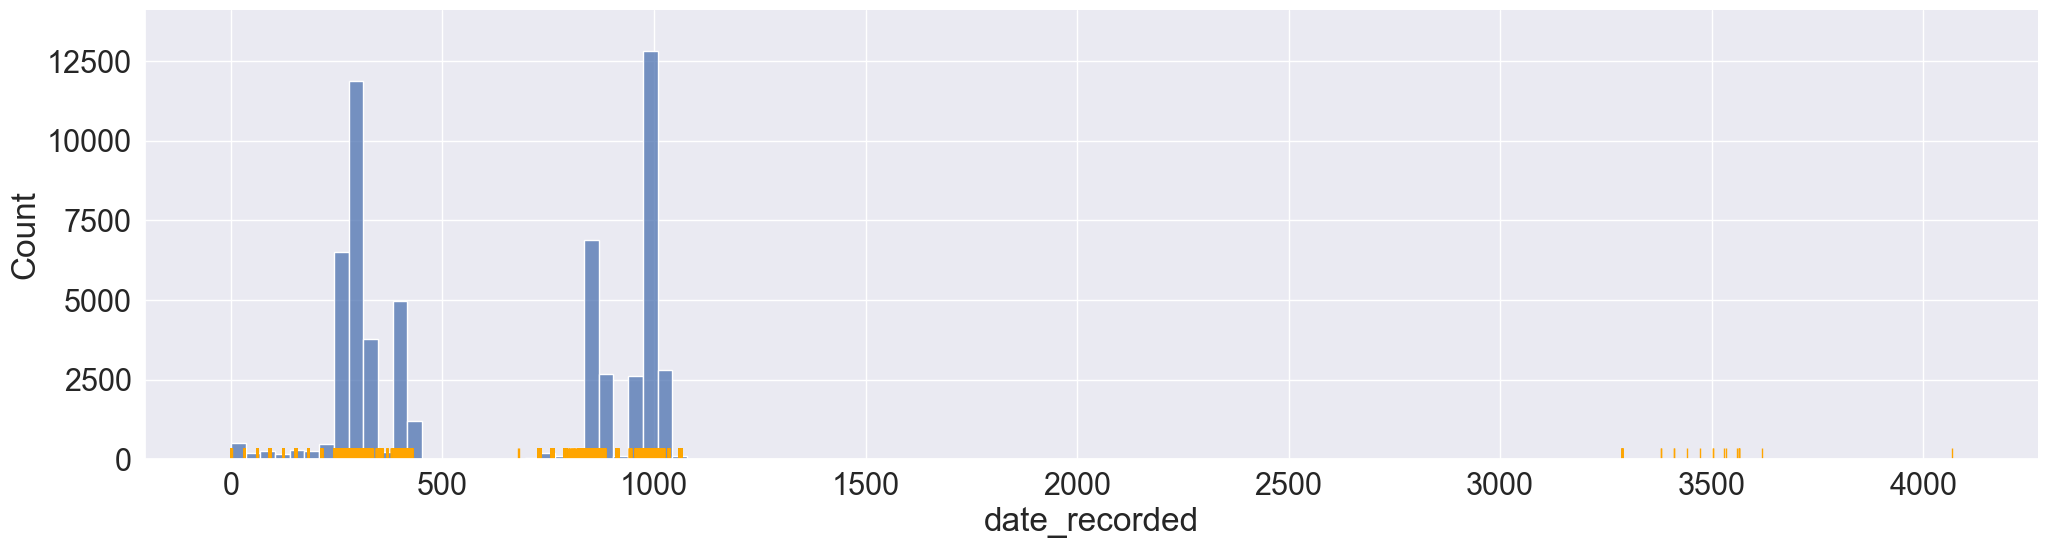

<AxesSubplot: xlabel='date_recorded'>

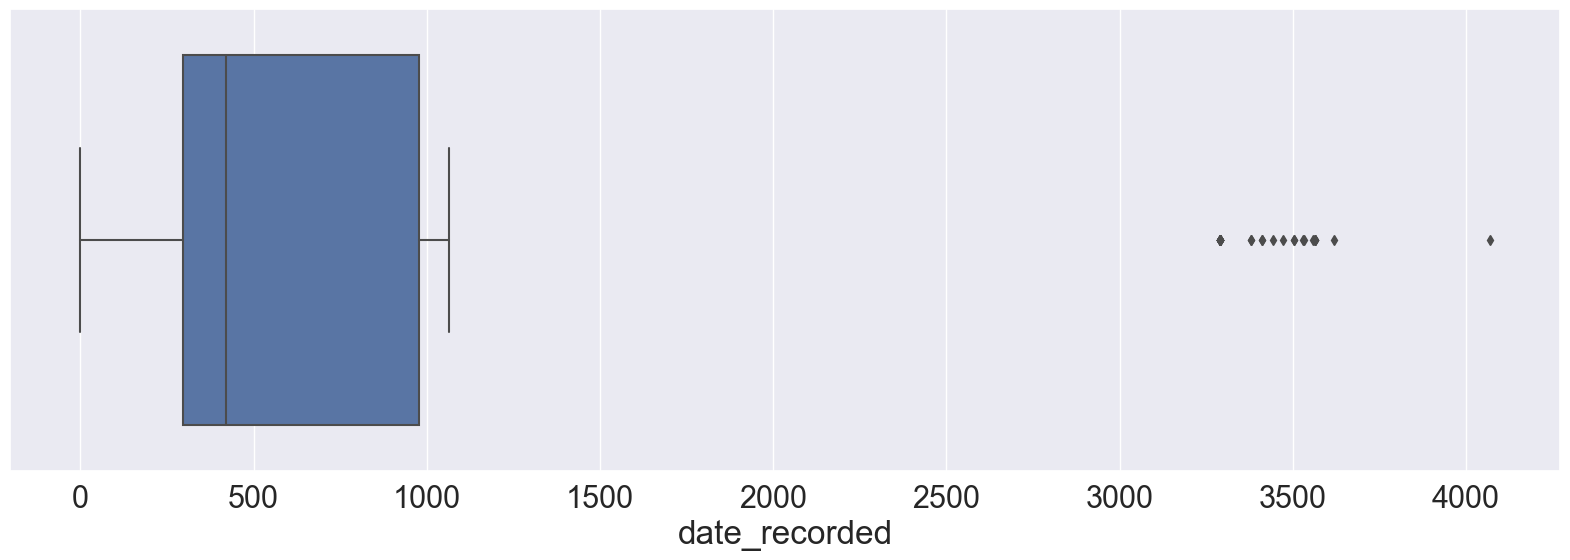

In [66]:
cramer = jd.cramers_v(df['date_recorded'],df["status_group"])
print(f"Asociación con la objetivo: {cramer}")
sns.displot(df['date_recorded'], height=6, aspect=3.5,kind='hist',rug=True, rug_kws={"color": "orange"})
plt.show()
sns.boxplot(df['date_recorded'])


### La limpieza sigue buscando las características con datos missing


In [67]:
[(x,y) for (x,y) in df.isna().sum().items() if y>0]

[('funder', 3635),
 ('installer', 3655),
 ('subvillage', 371),
 ('public_meeting', 3334),
 ('scheme_management', 3877),
 ('scheme_name', 28166),
 ('permit', 3056)]

## Funder e Installer

In [68]:
df[["funder","installer"]]
jd.cramers_v(df.funder,df.installer)
 # Son muy parecidos entre ellos, en lo que se borró había decidido hacerle drop al que tenía menor asociación cramer con la objetivo, pero en verdad, sabiendo que lo que mejor predice X_test es un random forest y que el 
# random forest no tiene problemas con la multicolinearidad, no hay necesidad de hacerle drop a ninguno.

# Justifico mi uso del IterativeImputer con la fuerte asociación de ambos con el resto del DataFrame
cramer_dict = {}
for i in df.columns:
    cramer= jd.cramers_v(df.funder,df[i])
    cramer_dict[i] = cramer
print("Top asociaciones del df con funder:")
print(pd.Series(cramer_dict).sort_values(ascending=False).head(10))
print()
cramer_dict = {}
for i in df.columns:
    cramer= jd.cramers_v(df.installer,df[i])
    cramer_dict[i] = cramer
print("Top asociaciones del df con installer:")
print(pd.Series(cramer_dict).sort_values(ascending=False).head(10))


Top asociaciones del df con funder:
funder               1.000000
wpt_name             0.802056
installer            0.765529
region               0.725681
construction_year    0.710562
latitude             0.702648
region_code          0.696729
basin                0.677196
scheme_name          0.669329
district_code        0.660757
dtype: float64

Top asociaciones del df con installer:
installer        1.000000
wpt_name         0.805723
region_code      0.779618
funder           0.765529
region           0.733605
district_code    0.732219
latitude         0.683255
lga              0.681476
basin            0.676127
scheme_name      0.668383
dtype: float64


In [69]:
def asociaciones_df_var(data,var,n=10,remove= ["id","num_private","recorded_by","random","random2"]):
    cramer_dict = {}
    columnas = data.columns.tolist()
    columnas.remove(var)
    for i in remove:
        columnas.remove(i)
    for col in columnas:
        cramer= jd.cramers_v(data[var],df[col])
        cramer_dict[col] = cramer
    print(f"Top {n} asociaciones del df con {var}:")
    print(pd.Series(cramer_dict).sort_values(ascending=False).head(n))


In [70]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'random', 'random2'],
      dtype='object')

In [71]:
drop_list  = ["scheme_name","management_group","num_private","recorded_by",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]#saco funder de la lista que no me funcnó tan mal y rectifico mi desciciçon de imputa con el immputador iterativo.

## wpt_name tiene dos missings, no tendrá mucho efecto en el resultado la técnica que utilice

## subvillage

Value counts:
[('Mwadudu', 1), ('Mwamagangati', 1), ('Mwaya B', 1), ('Mwandenga', 1), ('Mwadugulu', 1), ('Wimbwa', 1), ('Mwaduguru', 1), ('Zege', 1), ('Mwandunguku', 1), ('Mwabuliochi', 1), ('Mwandera', 1), ('Viwanjastini', 1), ('Mwanduu', 1), ('Mwadanga', 1), ('Mwasiti', 1), ('Mwabulandi', 1), ('Mwandutu', 1), ('Mwabukwimba', 1), ('Mwaya A', 1), ('Uwiga', 1), ('Mwanduominzi', 1), ('Mwadele', 1), ('Walisa', 1), ('Mwadole', 1), ('Wni Kati', 1), ('Mwamashele', 1), ('Zimbabwe', 1), ('Mzinga B', 1), ('Mwanza Ya Madaso', 1), ('Mwanya Shuleni', 1), ('Uwinwi', 1), ('Mwadegeleki', 1), ('Wingi', 1), ('Mwanyachiza', 1), ('Mwamagarani', 1), ('Mwasuta', 1), ('Mwabulilo', 1), ('Mwamasha', 1), ('Mwabunuri', 1), ('Mwanza Mangombe', 1), ('Mwandili A', 1), ('Mwandomo', 1), ('Mwasomi', 1), ('Mwandito', 1), ('Vikuruti', 1), ('Mzizini', 1), ('Mwamadilana', 1), ('Mwamasele', 1), ('Mwamachibya', 1), ('Mzungu B', 1), ('Mwamabulo', 1), ('Uwaya', 1), ('Mzungu Wa Sala', 1), ('Zelui', 1), ('Mwayole', 1), ('Viweg

Madukani          508
Shuleni           506
Majengo           502
Kati              373
Mtakuja           262
                 ... 
Gwashyi             2
Kilaweni Chini      2
Kisangari           2
Nyawami             2
Kiloa               2
Name: subvillage, Length: 9863, dtype: int64

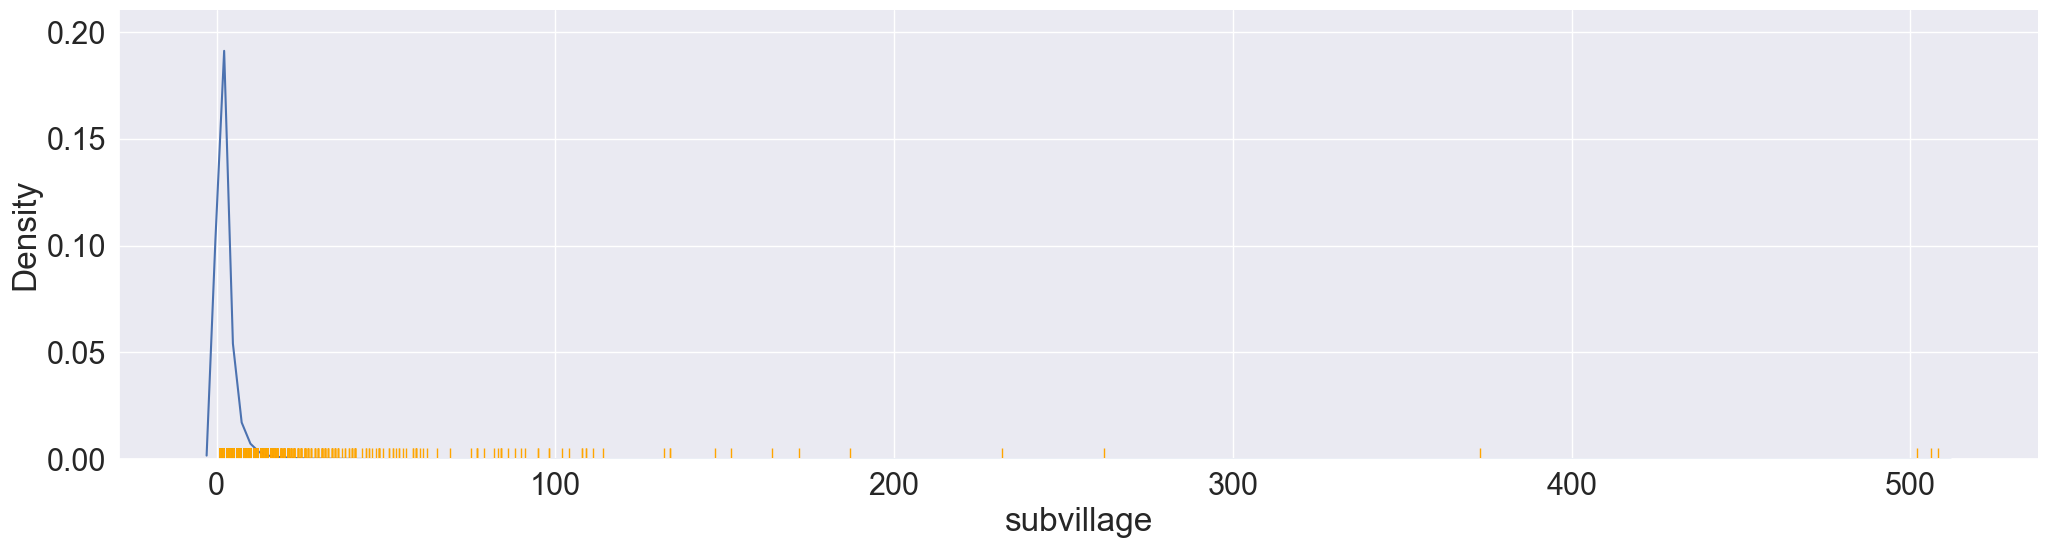

In [72]:
print("Value counts:")
print([(x,y) for (x,y) in df.subvillage.value_counts().items() if y==1])
# Demasiadas categorías de una sola aparición, crearé categoría de "poco frecuente" como recomendó el profesor y de la primera manera descrita en "Python Feature Engineering Cookbook"


freqs = df["subvillage"].value_counts(normalize=False)
freqs.sort_values(ascending=False)
# la categoría que más aparece, aparece sólo en el 0.8606% de los rows
sns.displot(freqs, height=6, aspect=3.5,kind='kde',rug=True, rug_kws={"color": "orange"})
freqs.loc[freqs!=1]


In [73]:
# En el libro se hace con frecuencias porcentuales, lo hago con números para ajustarlo de manera más fácil
frequent_cat = [
 x for x in freqs.loc[freqs > 3].index.values]

cramer = jd.cramers_v(df.subvillage,df.status_group)
print(f"Aosicación con la objetivo antes de agrupar categorías poco frecuentes: {cramer}")

# Agrupo las poco frecuentes
df["subvillage_agrupado"] = np.where(
 df["subvillage"].isin(frequent_cat),
 df["subvillage"], "Rare"
)
df.subvillage_agrupado = df.subvillage_agrupado.astype("category")
cramer = jd.cramers_v(df.subvillage_agrupado,df.status_group)
print(f"Aosicación con la objetivo después de agrupar categorías poco frecuentes: {cramer}")
"""
frequent_cat = [
 x for x in freqs.loc[freqs > 0.001].index.values]
Aosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041
Aosicación con la objetivo después de agrupar categorías poco frecuentes: 0.0585490865296918

Así como esta hice muchas iteraciones, lo que maximiza la asociación cramer es no agrupar, me quedo con la sin agrupar y con 3 porque el random forest no debería tener problemas con esto
"""

Aosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041
Aosicación con la objetivo después de agrupar categorías poco frecuentes: 0.4030543983122225


'\nfrequent_cat = [\n x for x in freqs.loc[freqs > 0.001].index.values]\nAosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041\nAosicación con la objetivo después de agrupar categorías poco frecuentes: 0.0585490865296918\n\nAsí como esta hice muchas iteraciones, lo que maximiza la asociación cramer es no agrupar, me quedo con la sin agrupar y con 3 porque el random forest no debería tener problemas con esto\n'

In [74]:
#asociaciones_df_var(df,"subvillage")
# en esta computadora recibo MemoryError: Unable to allocate 10.7 GiB for an array with shape (2, 721314513) and data type uint64, lo intentaré en la otra. Pero recuerdo que tenía fuerte asociación con las demás, por eso el IterativeImputer

## public_meeting

In [75]:
print(df.public_meeting.unique())
asociaciones_df_var(df,"public_meeting") # Fuerte asociación: IterativeImputer

[True, NaN, False]
Categories (2, bool): [False, True]
Top 10 asociaciones del df con public_meeting:
wpt_name               0.835721
scheme_name            0.801184
subvillage             0.792004
ward                   0.761752
lga                    0.518875
subvillage_agrupado    0.493667
installer              0.476018
funder                 0.460193
management             0.292456
scheme_management      0.268320
dtype: float64


## "scheme_management","scheme_name"

In [76]:
print(f"Cantidad de valores únicos en management: {df.scheme_management.nunique()},Cantidad de valores únicos en name: {df.scheme_name.nunique()}")
print(f"Asociaicón entre ambas;:{jd.cramers_v(df.scheme_management,df.scheme_name)}")
print("No parece que cada valor de name tenga un solo valor en management, no le haré drop a ninguno")

df[["scheme_management","scheme_name"]].loc[df["scheme_name"]=="Roman"].scheme_management.unique()
#df[["scheme_management","scheme_name"]] 



Cantidad de valores únicos en management: 12,Cantidad de valores únicos en name: 2696
Asociaicón entre ambas;:0.8393079825818669
No parece que cada valor de name tenga un solo valor en management, no le haré drop a ninguno


['VWC', 'Water Board']
Categories (12, object): ['Company', 'None', 'Other', 'Parastatal', ..., 'WUA', 'WUG', 'Water Board', 'Water authority']

In [77]:
drop_list  = ["management_group","num_private","recorded_by",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]

In [78]:
asociaciones_df_var(df,"scheme_name")# Fuerte asociación: IterativeImputer
print("---------------------------------")
asociaciones_df_var(df,"scheme_management")# Fuerte asociación: IterativeImputer

Top 10 asociaciones del df con scheme_name:
region_code          0.998184
district_code        0.993104
permit               0.953053
latitude             0.948803
basin                0.947012
construction_year    0.944865
region               0.942548
lga                  0.940041
gps_height           0.915532
longitude            0.905798
dtype: float64
---------------------------------
Top 10 asociaciones del df con scheme_management:
wpt_name               0.851814
scheme_name            0.839308
subvillage             0.770190
management             0.757020
ward                   0.728288
management_group       0.700172
installer              0.614885
lga                    0.595438
funder                 0.589592
subvillage_agrupado    0.557180
dtype: float64


##  permit

In [79]:
df.permit.value_counts(dropna=False)

cramer = jd.cramers_v(df.permit,df.status_group) # Asociación muy baja con la objetivo, pero no es razón para descartarla
print(f"Aosicación con la Objetivo: {cramer}")

asociaciones_df_var(df,"permit")# Fuerte asociación: IterativeImputer

Aosicación con la Objetivo: 0.034686416172701455
Top 10 asociaciones del df con permit:
scheme_name            0.953053
ward                   0.892290
subvillage             0.834607
wpt_name               0.827080
lga                    0.822143
installer              0.642906
funder                 0.620624
subvillage_agrupado    0.555618
region                 0.408145
scheme_management      0.292946
dtype: float64


# Reviso ahora las categorías que en la descipción parecen significar lo mismo

basin - Geographic water basin
subvillage - Geographic location

In [80]:
print(f"Cantidad de valores únicos en basin: {df.basin.nunique()},Cantidad de valores únicos en subvillage: {df.subvillage.nunique()}")

df[["basin","subvillage"]].loc[df["subvillage"]=="Majengo"].basin.unique()

#No parece que se cumpla que cada valor de subvillage se corresponde a uno solo de basin, dejo ambas

#df[["basin","subvillage"]]

Cantidad de valores únicos en basin: 9,Cantidad de valores únicos en subvillage: 19287


['Pangani', 'Lake Nyasa', 'Lake Rukwa', 'Rufiji', 'Ruvuma / Southern Coast', 'Lake Tanganyika', 'Internal', 'Lake Victoria', 'Wami / Ruvu']
Categories (9, object): ['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika', ..., 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast', 'Wami / Ruvu']

region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)

In [81]:
print(f"Cantidad de valores únicos en region: {df.region.nunique()},Cantidad de valores únicos en region_code: {df.region_code.nunique()},Cantidad de valores únicos en district_code: {df.district_code.nunique()}")
df[["region","region_code","district_code"]]

df[["region_code","district_code"]].loc[df["region_code"]==20].district_code.unique() #No parece que se cumpla que cada valor de district_code se corresponde a uno solo de region_code, dejo ambas

Cantidad de valores únicos en region: 21,Cantidad de valores únicos en region_code: 27,Cantidad de valores únicos en district_code: 20


array([2, 3, 4, 1, 6])

In [82]:
df[["region","region_code"]].loc[df["region_code"]==20].region.unique() 
# Para regiuon y region code sí parece que cada region code se corresponde a una sola region
df[["region","region_code"]].loc[df["region_code"]==21].region.unique() 

for i in df["region_code"].unique():
    if df[["region","region_code"]].loc[df["region_code"]==i].region.nunique() !=1:
        print(f"el code {i} se corresponde a más de una región")

df[["region_code","district_code"]].loc[df["region_code"]==11]#.district_code.unique() No le hago drop a ninguno de los tres con descripción "Geographic location"--> ojo: sólo aplica porque uso random forest

el code 11 se corresponde a más de una región
el code 18 se corresponde a más de una región
el code 17 se corresponde a más de una región
el code 14 se corresponde a más de una región
el code 5 se corresponde a más de una región


,region_code,district_code
0,11,5
16,11,4
17,11,4
19,11,5
20,11,4
...,...,...
59365,11,4
59367,11,3
59378,11,4
59380,11,5


lga - Geographic location
ward - Geographic location

In [83]:
print(f"Cantidad de valores únicos en lga: {df.lga.nunique()},Cantidad de valores únicos en region_code: {df.region_code.nunique()},Cantidad de valores únicos en ward: {df.ward.nunique()}")

df[["lga","ward"]]

Cantidad de valores únicos en lga: 125,Cantidad de valores únicos en region_code: 27,Cantidad de valores únicos en ward: 2092


,lga,ward
0,Ludewa,Mundindi
1,Serengeti,Natta
2,Simanjiro,Ngorika
3,Nanyumbu,Nanyumbu
4,Karagwe,Nyakasimbi
...,...,...
59395,Hai,Masama Magharibi
59396,Njombe,Ikondo
59397,Mbarali,Chimala
59398,Chamwino,Mvumi Makulu


### Hay 7 medidas de region y las he estado investigando por partes, la verdad es que para buscar si alguna es completamente redundante he de investigarla por sí sola

In [84]:
for i in df["lga"].unique():
    if df[["lga","region"]].loc[df["lga"]==i].region.nunique() !=1:
        print(f"el lga {i} se corresponde a más de una región")
        
for i in df["region"].unique():
    if df[["lga","region"]].loc[df["region"]==i].lga.nunique() !=1:
        print(f"la región {i} se corresponde a más de un lga")


print(jd.theils_u(df.lga,df.region_code))
print(jd.theils_u(df.region_code,df.lga))
# La U de Theil habla de probabiliad condicional, donde el resultado de P(x|y) != P(y|x)
# El 0.99 nos indica que con el valor de lga podemos predecir el valor de region con seguridad plena, por lo que de todas las medidas de geolocalización sólo es region completamente redundante

la región Iringa se corresponde a más de un lga
la región Mara se corresponde a más de un lga
la región Manyara se corresponde a más de un lga
la región Mtwara se corresponde a más de un lga
la región Kagera se corresponde a más de un lga
la región Tanga se corresponde a más de un lga
la región Shinyanga se corresponde a más de un lga
la región Tabora se corresponde a más de un lga
la región Pwani se corresponde a más de un lga
la región Ruvuma se corresponde a más de un lga
la región Kilimanjaro se corresponde a más de un lga
la región Rukwa se corresponde a más de un lga
la región Mwanza se corresponde a más de un lga
la región Kigoma se corresponde a más de un lga
la región Lindi se corresponde a más de un lga
la región Dodoma se corresponde a más de un lga
la región Arusha se corresponde a más de un lga
la región Mbeya se corresponde a más de un lga
la región Singida se corresponde a más de un lga
la región Morogoro se corresponde a más de un lga
la región Dar es Salaam se correspo

In [85]:
from itertools import combinations
columnas_geoloc = ["lga","ward","region","region_code","district_code","basin","subvillage"]


for var1, var2 in combinations(columnas_geoloc, 2):
    #var1 --> var2
    count = 0
    meta = df[var1].nunique()

    theil1 = jd.theils_u(df[var1],df[var2])
    if theil1>0.95:
        print(f"Qué tan seguro puedo estar del valor de {var1} cuando conozco {var2}: {theil1}")
        print("------------------------------")

    for i in df[var1].unique():
        if df[[var1, var2]].loc[df[var1]==i][var2].nunique() ==1:#if this valor de var1 siempre se corresponde al mismo valor de var2
            count+=1
        if count == meta:
            print("IMPORTANTE:")
            print(f"{var1} hace redundante a {var2}")

    #var2 --> var1
    count = 0
    meta = df[var2].nunique()

    theil2 = jd.theils_u(df[var2],df[var1])
    if theil2 > 0.95:
        print("------------------------------")
        print(f"Qué tan seguro puedo estar del valor de {var2} cuando conozco {var1}: {theil2}")

    for i in df[var2].unique():
        if df[[var2, var1]].loc[df[var2]==i][var1].nunique() ==1: 
            count+=1
        if count == meta:
            print(f"{var2} hace redundante a {var1}")
    print("")
    
            

Qué tan seguro puedo estar del valor de lga cuando conozco ward: 0.989549423173715
------------------------------

IMPORTANTE:
lga hace redundante a region
------------------------------
Qué tan seguro puedo estar del valor de region cuando conozco lga: 1.0

------------------------------
Qué tan seguro puedo estar del valor de region_code cuando conozco lga: 0.9941497519520324

------------------------------
Qué tan seguro puedo estar del valor de district_code cuando conozco lga: 0.9666097795302878



------------------------------
Qué tan seguro puedo estar del valor de region cuando conozco ward: 0.9858180047039892

------------------------------
Qué tan seguro puedo estar del valor de region_code cuando conozco ward: 0.9847275058133742

------------------------------
Qué tan seguro puedo estar del valor de district_code cuando conozco ward: 0.9710885613768153

------------------------------
Qué tan seguro puedo estar del valor de basin cuando conozco ward: 0.965489695588419


Qué 

In [86]:
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]#basin??

In [87]:
def check_redundancy(columnas, verbose = 0):
    """
    verbose controla la cantiadad de prints,
    0 muestra sólo cuando una columna es completamente redundate.
    1 te da el resultado de la U de Theil de las variables si este valor es mayor a 0.95
    2 te muestra cada categoría que siempre se corresponde al mismo valor en otra columna
    """
    from itertools import combinations
    for var1, var2 in combinations(columnas, 2):
        #var1 --> var2
        count = 0
        meta = df[var1].nunique()
        
        theil1 = jd.theils_u(df[var1],df[var2])
        if theil1>0.95:
            if verbose > 0:
                print(f"Qué tan seguro puedo estar del valor de {var1} cuando conozco {var2}: {theil1}")
            
        lista1 = []
        for i in df[var1].unique():
            if df[[var1, var2]].loc[df[var1]==i][var2].nunique() ==1:#if this valor de var1 siempre se corresponde al mismo valor de var2
                lista1.append(i)
                count+=1
            if count == meta:
                print("------------------------------")
                print("IMPORTANTE:")
                print(f"{var1} hace redundante a {var2}")
                print("------------------------------")
        if verbose > 1:
            print(f"los siguientes valores de {var1} tienen asociados siempre el mismo valor en {var2}")
            print(lista1)



        #var2 --> var1
        count = 0
        meta = df[var2].nunique()
        
        theil2 = jd.theils_u(df[var2],df[var1])
        if theil2 > 0.95:
            if verbose > 0:
                print(f"Qué tan seguro puedo estar del valor de {var2} cuando conozco {var1}: {theil2}")

        lista2 = []
        for i in df[var2].unique():
            if df[[var2, var1]].loc[df[var2]==i][var1].nunique() ==1: 
                count+=1
                lista2.append(i)
            if count == meta:
                print("------------------------------")
                print("IMPORTANTE:")
                print(f"{var2} hace redundante a {var1}")
                print("------------------------------")
        if verbose > 1:
            print(f"los siguientes valores de {var2} tienen asociados siempre el mismo valor en {var1}")
            print(lista1)
    
         

## "scheme_management","scheme_name" tienen la misma descripción

In [88]:
check_redundancy(["scheme_management","scheme_name"],verbose=2) #no prints

los siguientes valores de scheme_management tienen asociados siempre el mismo valor en scheme_name
[]
los siguientes valores de scheme_name tienen asociados siempre el mismo valor en scheme_management
[]


In [89]:
check_redundancy(["lga","ward","region","region_code","district_code","basin","subvillage"],verbose=0)

------------------------------
IMPORTANTE:
lga hace redundante a region
------------------------------


In [90]:
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

## "extraction_type","extraction_type_group","extraction_type_class" tienen la misma descripción

In [91]:
check_redundancy(["extraction_type","extraction_type_group","extraction_type_class"],verbose=2) 

Qué tan seguro puedo estar del valor de extraction_type cuando conozco extraction_type_group: 0.9656098168177001
------------------------------
IMPORTANTE:
extraction_type hace redundante a extraction_type_group
------------------------------
los siguientes valores de extraction_type tienen asociados siempre el mismo valor en extraction_type_group
['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii', 'other', 'ksb', 'mono', 'windmill', 'afridev', 'other - rope pump', 'india mark iii', 'other - swn 81', 'other - play pump', 'cemo', 'climax', 'walimi', 'other - mkulima/shinyanga']
Qué tan seguro puedo estar del valor de extraction_type_group cuando conozco extraction_type: 1.0
los siguientes valores de extraction_type_group tienen asociados siempre el mismo valor en extraction_type
['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii', 'other', 'ksb', 'mono', 'windmill', 'afridev', 'other - rope pump', 'india mark iii', 'other - swn 81', 'other - play pump', 

In [92]:
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio
#group y class se quedan!!!!

## "management","management_group"tienen la misma descripción

In [93]:
check_redundancy(["management","management_group"],verbose=2) 

------------------------------
IMPORTANTE:
management hace redundante a management_group
------------------------------
los siguientes valores de management tienen asociados siempre el mismo valor en management_group
['vwc', 'wug', 'other', 'private operator', 'water board', 'wua', 'company', 'water authority', 'parastatal', 'unknown', 'other - school', 'trust']
Qué tan seguro puedo estar del valor de management_group cuando conozco management: 1.0
los siguientes valores de management_group tienen asociados siempre el mismo valor en management
['vwc', 'wug', 'other', 'private operator', 'water board', 'wua', 'company', 'water authority', 'parastatal', 'unknown', 'other - school', 'trust']


In [94]:
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

#"region","region_code" se quedan PERO MOSCA QUE CODE NO ES 100% REDUNDANTE
# extraction_type group y class se quedan!!!!
# management_group se queda

## "payment","payment_type" tienen la misma descripción

In [95]:
check_redundancy(["payment","payment_type"],verbose=2) 


Qué tan seguro puedo estar del valor de payment cuando conozco payment_type: 1.0
------------------------------
IMPORTANTE:
payment hace redundante a payment_type
------------------------------
los siguientes valores de payment tienen asociados siempre el mismo valor en payment_type
['pay annually', 'never pay', 'pay per bucket', 'unknown', 'pay when scheme fails', 'other', 'pay monthly']
Qué tan seguro puedo estar del valor de payment_type cuando conozco payment: 1.0
------------------------------
IMPORTANTE:
payment_type hace redundante a payment
------------------------------
los siguientes valores de payment_type tienen asociados siempre el mismo valor en payment
['pay annually', 'never pay', 'pay per bucket', 'unknown', 'pay when scheme fails', 'other', 'pay monthly']


In [96]:
print(df.payment.nunique())
df.payment_type.nunique()

7


7

In [97]:
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

#"region","region_code" se quedan PERO MOSCA QUE CODE NO ES 100% REDUNDANTE
# extraction_type group y class se quedan!!!!
# management_group se queda
# Payment SE QUEDA


## "water_quality","quality_group", tienen la misma descripción

In [98]:
check_redundancy(["water_quality","quality_group"],verbose=2) 

Qué tan seguro puedo estar del valor de water_quality cuando conozco quality_group: 0.9629320818479418
------------------------------
IMPORTANTE:
water_quality hace redundante a quality_group
------------------------------
los siguientes valores de water_quality tienen asociados siempre el mismo valor en quality_group
['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured', 'salty abandoned', 'fluoride abandoned']
Qué tan seguro puedo estar del valor de quality_group cuando conozco water_quality: 1.0
los siguientes valores de quality_group tienen asociados siempre el mismo valor en water_quality
['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured', 'salty abandoned', 'fluoride abandoned']


In [99]:
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

#"region","region_code" se quedan PERO MOSCA QUE CODE NO ES 100% REDUNDANTE
# extraction_type group y class se quedan!!!!
# management_group se queda
# Payment SE QUEDA
# Los quality y quantity groups son redundantes


## "quantity","quantity_group"tienen la misma descripción

In [100]:
check_redundancy(["quantity","quantity_group"],verbose=2) 

Qué tan seguro puedo estar del valor de quantity cuando conozco quantity_group: 1.0
------------------------------
IMPORTANTE:
quantity hace redundante a quantity_group
------------------------------
los siguientes valores de quantity tienen asociados siempre el mismo valor en quantity_group
['enough', 'insufficient', 'dry', 'seasonal', 'unknown']
Qué tan seguro puedo estar del valor de quantity_group cuando conozco quantity: 1.0
------------------------------
IMPORTANTE:
quantity_group hace redundante a quantity
------------------------------
los siguientes valores de quantity_group tienen asociados siempre el mismo valor en quantity
['enough', 'insufficient', 'dry', 'seasonal', 'unknown']


In [101]:
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

#"region","region_code" se quedan PERO MOSCA QUE CODE NO ES 100% REDUNDANTE
# extraction_type group y class se quedan!!!!
# management_group se queda
# Payment SE QUEDA
# Los quality y quantity groups son redundantes
# ,"source_class","source_type" se quedan

## "source","source_type", "source_class" tienen la misma descripción

In [102]:
check_redundancy(["source","source_type", "source_class"],verbose=2) 

------------------------------
IMPORTANTE:
source hace redundante a source_type
------------------------------
los siguientes valores de source tienen asociados siempre el mismo valor en source_type
['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other', 'shallow well', 'river', 'hand dtw', 'lake', 'unknown']
Qué tan seguro puedo estar del valor de source_type cuando conozco source: 1.0
los siguientes valores de source_type tienen asociados siempre el mismo valor en source
['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other', 'shallow well', 'river', 'hand dtw', 'lake', 'unknown']
------------------------------
IMPORTANTE:
source hace redundante a source_class
------------------------------
los siguientes valores de source tienen asociados siempre el mismo valor en source_class
['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other', 'shallow well', 'river', 'hand dtw', 'lake', 'unknown']
Qué tan seguro puedo estar del valor de source_class cuando conozco

In [103]:
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

#"region","region_code" se quedan PERO MOSCA QUE CODE NO ES 100% REDUNDANTE
# extraction_type group y class se quedan!!!!
# management_group se queda
# Payment SE QUEDA
# Los quality y quantity groups son redundantes
# ,"source_class","source_type" se quedan

## "waterpoint_type","waterpoint_type_group" tienen la misma descripción

In [104]:
check_redundancy(["waterpoint_type","waterpoint_type_group"],verbose=2) 

------------------------------
IMPORTANTE:
waterpoint_type hace redundante a waterpoint_type_group
------------------------------
los siguientes valores de waterpoint_type tienen asociados siempre el mismo valor en waterpoint_type_group
['communal standpipe', 'communal standpipe multiple', 'hand pump', 'other', 'improved spring', 'cattle trough', 'dam']
Qué tan seguro puedo estar del valor de waterpoint_type_group cuando conozco waterpoint_type: 1.0
los siguientes valores de waterpoint_type_group tienen asociados siempre el mismo valor en waterpoint_type
['communal standpipe', 'communal standpipe multiple', 'hand pump', 'other', 'improved spring', 'cattle trough', 'dam']


In [105]:
drop_list_no_sirven  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

#"region","region_code" se quedan PERO MOSCA QUE CODE NO ES 100% REDUNDANTE
# extraction_type group y class se quedan!!!!
# management_group se queda
# Payment SE QUEDA
# Los quality y quantity groups son redundantes
# ,"source_class","source_type" se quedan
#waterpoint_type_group se queda

drop_modelo_ceroochounocinco  = ["management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"] #permit","population","amount_tsh" eran drops que funcionaban bien al principio

In [114]:
mejor_drop_list  = ["scheme_name","funder","management_group","num_private","recorded_by",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group"]

drop_modelo_ceroochounocinco  = ["management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]

en_mejor_pero_no_en_mio = [x for x in mejor_drop_list if x not in drop_modelo_ceroochounocinco]
en_mio_pero_no_en_mejor = [x for x in drop_modelo_ceroochounocinco if x not in mejor_drop_list]

print("Variables en el drop list de los mejores resultados 0.8170, que no están en mi preferido 0.8150")
print(en_mejor_pero_no_en_mio)
print("----------------------")
print("Variables en mi drop list preferido 0.8150 que no están en el de los mejores resultados 0.8170")
print(en_mio_pero_no_en_mejor)

Variables en el drop list de los mejores resultados 0.8170, que no están en mi preferido 0.8150
['scheme_name', 'funder', 'source']
----------------------
Variables en mi drop list preferido 0.8150 que no están en el de los mejores resultados 0.8170
['region', 'region_code', 'permit', 'population', 'amount_tsh']


## El drop_list no me dio los resultados que esperaba, quiesiera mejorar mi función para que me analice cuál de las características redundantes tiene mayor asociación cramer con la objetivo. 

## Pero no quiero perder demasiado tiempo evaluando qué variables obviar, antes que eso desarrollaré una función que pruebe los distintos tipos de encoding para cada variable y así quedarme con el mejor para cada quien en vez de usa el ordinal encoder para todas.

In [115]:
drop_modelo_ceroochounocincodos  = ["management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]

# ESTE ES EL DROP LIST QUE SEGUIRÉ USANDO POR AHORA, ES EL QUE MÁS SENTIDO SU ACCURACY AUNQUE SEA 0.02 MENOR QUE EL MEJOR

(*) For full compatibility with Pipelines and ColumnTransformers, and consistent behaviour of get_feature_names_out, it’s recommended to upgrade sklearn to a version at least ‘1.2.0’ and to set output as pandas:

import sklearn
sklearn.set_config(transform_output="pandas")

Name: scikit-learn
Version: 1.2.2 Dios mediante me funciona

In [1]:
import pandas as pd
import numpy as np

import jd 
from optbinning import MulticlassOptimalBinning

import plotly.express as px
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 6]  # Width, Height

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score

#import warnings
#warnings.filterwarnings("ignore")

(CVXPY) Apr 19 02:07:10 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 19 02:07:10 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,TargetEncoder,LabelEncoder,StandardScaler
from category_encoders import WOEEncoder, CountEncoder
from sklearn.cluster import KMeans

### La función prueba ser un desafío muy grande, pero en verdad entretenido, me ha dado problemas con básicamente todo lo posible. Sé que dijeron que dejásemos todo lo hecho escrito, dejar todos los borraodres de esto dejaría un caos terrorífico.

In [3]:
def encode(X,y,column,tipo,OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols,num_cols):
    X_copy = X.copy()
    y_copy = y.copy()

    preprocessing = ColumnTransformer([
        ('ordinal', OrdinalEncoder(handle_unknown="use_encoded_value",
                                    unknown_value=10000000,
                                    encoded_missing_value =10000001,
                                    min_frequency = 0.01), OrdinalEncoder_cols),
        #arreglar:
        ('onehot', OneHotEncoder(max_categories=7,# Si existen más de 6 valores únicos crea categoría "infrequent"
                                    handle_unknown ="infrequent_if_exist",
                                    drop="first",sparse_output=False), OnehotEnc_cols),

        ('target', TargetEncoder(target_type="multiclass",
                                    cv=2,), TargetEnc_cols),  # default cv 5 me tardaría una eternidad
                                    
        ('Frequency', CountEncoder(handle_unknown="value",
                                    handle_missing="value"), FrequencyEnc_cols),                             
        ('scaler', StandardScaler(), num_cols),  
    ],
    remainder = "passthrough",
    )

    #X_copy = pd.DataFrame(data=preprocessing.fit_transform(X_copy,y=y_copy.status_group.values), columns=preprocessing.get_feature_names_out())
    X_copy = pd.DataFrame(data=preprocessing.fit_transform(X_copy,y=y_copy), columns=preprocessing.get_feature_names_out())
    
    
    if tipo == "train_test":
        X_train, X_test, y_train, y_test = train_test_split(X_copy, y_copy, test_size=0.2, random_state=23)
        rf = RandomForestClassifier(n_jobs=-1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_test)
        score = accuracy_score(y_test,y_pred)

    elif tipo == "KFold":
        rf = RandomForestClassifier(n_jobs=-1)
        score = cross_validate(rf, X_copy, y_copy, cv=4,scoring = "accuracy",n_jobs=-1)

    return score

In [4]:
def preprocess(X,y):
    for i in X.select_dtypes(include = "O").columns:
        X[i] = X[i].astype("category")

    le= LabelEncoder()
    #y["status_group"] = le.fit_transform(y.status_group)
    y = le.fit_transform(y.status_group)

    #Fechas------------------------------------------------------------------------ 
    X.date_recorded = X.date_recorded.astype("O")
    X.date_recorded = pd.to_datetime(X.date_recorded)
    X['date_recorded'] = (X.date_recorded.max() - X.date_recorded).dt.days
    #Drop list ------------------------------------------------------------------------ 
    drop_list  = ["id","management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]
    #Clusters de latitud y longitud------------------------------------------------------------------------   
    clustering = KMeans(n_clusters=20)
    X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
    
    #Marcar 0 en amount como dijo optbinning------------------------------------------------------------------------   
    X.loc[X["amount_tsh"].between(-np.inf,1.5),"amount_tsh_binned"] = 0
    X.loc[X["amount_tsh"].between(1.5,np.inf),"amount_tsh_binned"] = 1

    return X,y

In [5]:
def best_encoding_technique(tipo = "train_test"):
    """
    Función que eliminará subjetividad de la elección de técnica de encoding.
    Probará las siguientes técnicas con validación cruzada repetida o con un X_test

    se hace sin previamente imputar porque para imputar por un imputador no simple deja error:
    ValueError: Cannot cast object dtype to float64.
    Se imputará con el propio encoder usando una de las técnicas de imputación que viene con ellos por defecto
    """
    
    X = pd.read_csv("In/Training_set_values.csv")#uso X y Y frescas 
    y = pd.read_csv("In/Training_set_labels.csv")
    
    X,y = preprocess(X,y)

    cols_to_test = X.select_dtypes(exclude=np.number).columns.tolist()


    num_cols = X.select_dtypes(include=np.number).columns.tolist()

    OrdinalEncoder_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    OnehotEnc_cols = []
    TargetEnc_cols = []
    #WOEENC_cols = []# no creo que sus resultados varíen mucho del TargetEnc_cols. No funciona para objetivos multiclass
    FrequencyEnc_cols = [] #busca category encoders
    
    my_dict = {
    "OrdinalEncoder_cols": OrdinalEncoder_cols,
    "OnehotEnc_cols": OnehotEnc_cols,
    "TargetEnc_cols": TargetEnc_cols,
    "FrequencyEnc_cols": FrequencyEnc_cols
    }
    encoder_list = [OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols]

    for column in cols_to_test:
        list_to_keep_track_of_score = []

        for encoder in my_dict.values():
            #remove if exists from all lists
            if column in OrdinalEncoder_cols:
                OrdinalEncoder_cols.remove(column)

            elif column in OnehotEnc_cols:
                OnehotEnc_cols.remove(column)

            elif column in TargetEnc_cols:
                TargetEnc_cols.remove(column)

            elif column in FrequencyEnc_cols:
                FrequencyEnc_cols.remove(column)

            #appendo a lista respectiva y le saco el socore
            encoder.append(column)
            score = encode(X,y,column,tipo,OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols,num_cols)
            list_to_keep_track_of_score.append(score)
            #Lo saco de la columna testeada
            encoder.remove(column)

        
        # Lo apendo 
        encoder_list[np.argmax(list_to_keep_track_of_score)].append(column)

        
    return my_dict


In [7]:
"""
dict = best_encoding_technique(tipo="train_test")
# solo 3 minutos


for key,val in zip(dict.keys(),dict.values()):
    print("---------------------------------------------------------------")
    print(f"variables en {key.upper()}")
    print(val)


---------------------------------------------------------------
variables en ORDINALENCODER_COLS
['funder', 'wpt_name', 'lga', 'public_meeting', 'extraction_type', 'extraction_type_group', 'management', 'management_group', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']
---------------------------------------------------------------
variables en ONEHOTENC_COLS
['subvillage', 'scheme_management', 'permit', 'payment', 'source', 'waterpoint_type']
---------------------------------------------------------------
variables en TARGETENC_COLS
[]
---------------------------------------------------------------
variables en FREQUENCYENC_COLS
['installer', 'basin', 'region', 'ward', 'recorded_by', 'scheme_name', 'extraction_type_class', 'quantity_group', 'source_type']
"""

---------------------------------------------------------------
variables en ORDINALENCODER_COLS
['scheme_management', 'permit', 'extraction_type_class', 'management_group', 'quantity']
---------------------------------------------------------------
variables en ONEHOTENC_COLS
['region', 'lga', 'public_meeting', 'scheme_name', 'management', 'payment', 'waterpoint_type_group']
---------------------------------------------------------------
variables en TARGETENC_COLS
['wpt_name', 'recorded_by', 'water_quality', 'source_class']
---------------------------------------------------------------
variables en FREQUENCYENC_COLS
['funder', 'installer', 'basin', 'subvillage', 'ward', 'extraction_type', 'extraction_type_group', 'payment_type', 'quality_group', 'quantity_group', 'source', 'source_type', 'waterpoint_type']


"\n---------------------------------------------------------------\nvariables en ORDINALENCODER_COLS\n['funder', 'wpt_name', 'lga', 'public_meeting', 'extraction_type', 'extraction_type_group', 'management', 'management_group', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source_class', 'waterpoint_type_group']\n---------------------------------------------------------------\nvariables en ONEHOTENC_COLS\n['subvillage', 'scheme_management', 'permit', 'payment', 'source', 'waterpoint_type']\n---------------------------------------------------------------\nvariables en TARGETENC_COLS\n[]\n---------------------------------------------------------------\nvariables en FREQUENCYENC_COLS\n['installer', 'basin', 'region', 'ward', 'recorded_by', 'scheme_name', 'extraction_type_class', 'quantity_group', 'source_type']\n"

In [8]:
dict = best_encoding_technique(tipo="KFold")


NameError: name 'cross_validate' is not defined

In [ ]:
for key,val in zip(dict.keys(),dict.values()):
    print("---------------------------------------------------------------")
    print(f"variables en {key.upper()}")
    print(val)